## Pipeline (subject to change)

## INPUTS and OUTPUTS (SET BY USER)

In [73]:
# INPUTS
input_file = 'Coffee_Beans_HILIC_POS_RAW_20240105.csv'
input_batch_info_file = 'Coffee_Beans_HILIC_POS_RAW_20240105_InputFiles.csv'

# OUTPUTS
output_file_prefix = 'Coffee_Beans_HILIC_POS'
report_file_name = 'Coffee_Beans_HILIC_POS-report'

# OUTPUT FOLDER
main_folder = 'Coffee_analysis-POS'

## Creating folders

In [74]:
import os

# Create the directory if it doesn't exist
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# Create the directory if it doesn't exist
if not os.path.exists(main_folder + '/figures'):
    os.makedirs(main_folder + '/figures')

### Loading models

In [75]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import time
import math
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import LeaveOneOut
from scipy.stats import zscore

## Image formats to save

In [76]:
# To work properly always save atleast png version of the figures
sufixes = ['.png', '.pdf'] # sufices for the image files to be saved in

### Setting up the report file

In [77]:
import pdf_reporter as pdf_rptr

# Reload the module to get the latest changes
# This will be deleted later, just for testing purposes
import importlib
importlib.reload(pdf_rptr)



#---------------------------------------------
# REPORTING
report_path = main_folder + '/' + report_file_name + '.pdf'
title_text = main_folder

report = pdf_rptr.Report(name = report_path, title = title_text)
report.initialize_report('processing')

### Loading data

In [78]:
# Step 1: Read the data_df from Compound Discoverer file
data_file = input_file  # Update with your file path
data_df = pd.read_csv(data_file, sep = ';',  encoding='ISO-8859-1')
#data_df.head()

#---------------------------------------------
# REPORTING
text = 'Data were loaded from: ' + data_file + ' (data from Compound Discoverer).'
report.add_together([('text', text), 
                     ('table', data_df),
                     'line'])


### cpdID

In [79]:
#add cpdID column to the data_df calculated from mz and RT
data_df['cpdID'] = 'M' + data_df['m/z'].round(0).astype(int).astype(str) + 'T' + (data_df['RT [min]']*60).round(0).astype(int).astype(str)
# Create a new column 'Duplicate_Count' to keep track of the duplicates
data_df['Duplicate_Count'] = data_df.groupby('cpdID').cumcount()
# Create a mask to identify duplicated compounds
is_duplicate = data_df['Duplicate_Count'] > 0
# Update the 'Compound_ID' column for duplicated compounds
data_df.loc[is_duplicate, 'cpdID'] = data_df['cpdID'] + '_' + (data_df['Duplicate_Count']).astype(str)
# Drop the 'Duplicate_Count' 
data_df.drop('Duplicate_Count', axis=1, inplace=True)
#check if there are rly no duplicates left
remaining_duplicates = data_df[data_df['cpdID'].duplicated(keep=False)]
print(remaining_duplicates.empty)

#---------------------------------------------
# REPORTING
text = 'cpdID column was added to the data_df calculated from mz and RT. Matching ID - distinguished by adding "_1", "_2", etc.'
report.add_together([('text', text),
                        'line'])

data_df

True


,ï»¿Tags,Checked,Name,Formula,Annot. Source: Predicted Compositions,Annot. Source: mzCloud Search,Annot. Source: mzVault Search,Annot. Source: Metabolika Search,Annot. Source: ChemSpider Search,Annot. Source: MassList Search,...,Peak Rating: QC17_POS.raw (F103),Peak Rating: QC18_POS.raw (F104),Peak Rating: QC19_POS.raw (F105),Peak Rating: QC20_POS.raw (F106),Peak Rating: QC21_POS.raw (F107),Peak Rating: QC22_POS.raw (F108),Peak Rating: QC23_POS.raw (F109),Peak Rating: QC24_POS.raw (F110),Peak Rating: QC25_POS.raw (F111),cpdID
0,NaN,NEPRAVDA,2-Hydroxybenzamide,C7 H7 N O2,Full match,No results,No results,Partial match,Not the top hit,Full match,...,7.6,7.1,8.2,7.1,7.6,6.6,6.6,7.1,7.1,M138T350
1,NaN,NEPRAVDA,Cafeine,C8 H10 N4 O2,Full match,No results,No results,Partial match,Partial match,Full match,...,9.7,9.7,9.7,9.7,9.7,9.7,9.7,9.7,9.7,M195T46
2,NaN,NEPRAVDA,(Hexanoylamino)acetate,C8 H14 N O3,No results,No results,No results,No results,Full match,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M195T46_1
3,NaN,NEPRAVDA,NaN,NaN,No results,No results,No results,No results,No results,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M195T45
4,NaN,NEPRAVDA,Aniline,C6 H7 N,Full match,Full match,No results,No results,Partial match,Full match,...,6.0,7.0,4.4,6.0,5.5,6.0,5.5,7.0,5.5,M94T225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,NaN,NEPRAVDA,Delphinidin,C15 H11 O7,No match,No results,No results,No results,Not the top hit,Full match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M304T313
6127,NaN,NEPRAVDA,"N-(3,5-Dimethoxyphenyl)-3-[4-(2-hydroxyethyl)-...",C17 H27 N3 O4,No results,No results,No results,No results,Full match,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M338T311
6128,NaN,NEPRAVDA,"PA(12:0/18:2(9Z,12Z))",C33 H61 O8 P,No match,No results,No results,No results,Not the top hit,Full match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M617T38
6129,NaN,NEPRAVDA,"PA(12:0/18:3(6Z,9Z,12Z))",C33 H59 O8 P,Not the top hit,No results,No results,No results,No match,Full match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M615T38


## Creating different matrices

### variable_metadata

In [80]:
variable_metadata = data_df[['cpdID', 'Name', 'Formula']]
variable_metadata = variable_metadata.join(data_df.iloc[:, 10:15])
variable_metadata = variable_metadata.join(data_df.iloc[:, 18:23])
variable_metadata = variable_metadata.join(data_df.iloc[:, 32:34])

#---------------------------------------------
# REPORTING
text = 'variable-metadata matrix was created.'
report.add_together([('text', text),
                        'line'])

variable_metadata


,cpdID,Name,Formula,Annot. DeltaMass [ppm],Annotation MW,Calc. MW,m/z,RT [min],# mzVault Results,CSID,SMILES,InChI Key,mzCloud Best Match,Mass List Match: Natural Products Atlas 2021_08,Mass List Match: LipidMaps Structure Database 2023-01-11
0,M138T350,2-Hydroxybenzamide,C7 H7 N O2,-1.68,137.04768,137.04745,138.05472,5.829,0,4963.0,c1ccc(c(c1)C(=O)N)O,SKZKKFZAGNVIMN-UHFFFAOYSA-N,NaN,Multiple matches found,No matches found
1,M195T46,Cafeine,C8 H10 N4 O2,-1.68,194.08038,194.08005,195.08733,0.759,0,NaN,NaN,NaN,NaN,Single match found,No matches found
2,M195T46_1,(Hexanoylamino)acetate,C8 H14 N O3,4.04,172.09737,172.09806,195.08728,0.765,0,1271264.0,CCCCCC(=O)NCC(=O)[O-],UPCKIPHSXMXJOX-UHFFFAOYSA-M,NaN,No matches found,No matches found
3,M195T45,NaN,NaN,NaN,NaN,156.12419,195.08735,0.756,0,NaN,NaN,NaN,NaN,No matches found,No matches found
4,M94T225,Aniline,C6 H7 N,-1.38,93.05785,93.05772,94.06500,3.744,0,5889.0,c1ccc(cc1)N,PAYRUJLWNCNPSJ-UHFFFAOYSA-N,96.8,No matches found,No matches found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,M304T313,Delphinidin,C15 H11 O7,-1.35,303.05048,303.05007,304.05735,5.213,0,114185.0,c1c(cc(c(c1O)O)O)c2c(cc3c(cc(cc3[o+]2)O)O)O,JKHRCGUTYDNCLE-UHFFFAOYSA-O,NaN,No matches found,Multiple matches found
6127,M338T311,"N-(3,5-Dimethoxyphenyl)-3-[4-(2-hydroxyethyl)-...",C17 H27 N3 O4,-1.82,337.20016,337.19954,338.20679,5.189,0,628050.0,COc1cc(cc(c1)OC)NC(=O)CCN2CCN(CC2)CCO,WJXXLQYTSJZGOL-UHFFFAOYSA-N,NaN,No matches found,No matches found
6128,M617T38,"PA(12:0/18:2(9Z,12Z))",C33 H61 O8 P,-0.65,616.41041,616.41001,617.41728,0.628,0,NaN,NaN,NaN,NaN,No matches found,Multiple matches found
6129,M615T38,"PA(12:0/18:3(6Z,9Z,12Z))",C33 H59 O8 P,-1.80,614.39476,614.39365,615.40092,0.627,0,NaN,NaN,NaN,NaN,No matches found,Multiple matches found


### data

In [81]:
data = data_df[['cpdID']]
# Select columns with names starting with "Area:"
area_columns = data_df.filter(regex=r'^Area:', axis=1) #for those starting with Area:, for those including Area anywhere, you can use like='Area:'
data = data.join(data_df[area_columns.columns])

# Fill NaN values with zero (NaN values are problem when plotted, and we will treat 0s as missing values later)
data.fillna(0, inplace=True)  # Replace NaN with 0

#---------------------------------------------
# REPORTING
text = 'data matrix was created.'
report.add_together([('text', text),
                        'line'])

data

,cpdID,Area: HN_Ol_01_R_POS.raw (F63),Area: HN_Ol_02_R_POS.raw (F64),Area: HN_Ol_03_R_POS.raw (F65),Area: Bez_Op_01_R_POS.raw (F4),Area: Bez_Op_02_R_POS.raw (F5),Area: Bez_Op_03_R_POS.raw (F6),Area: BLANK01_POS.raw (F7),Area: BLANK02_POS.raw (F8),Area: B_K_01_R_POS.raw (F1),...,Area: QC16_POS.raw (F102),Area: QC17_POS.raw (F103),Area: QC18_POS.raw (F104),Area: QC19_POS.raw (F105),Area: QC20_POS.raw (F106),Area: QC21_POS.raw (F107),Area: QC22_POS.raw (F108),Area: QC23_POS.raw (F109),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111)
0,M138T350,1.739578e+09,1.781533e+09,1.799165e+09,1.803171e+09,1.764705e+09,1.765961e+09,1.441664e+07,2.250933e+06,1.691837e+09,...,1.937816e+09,1.909850e+09,1.979890e+09,1.998663e+09,1.873791e+09,1.871787e+09,1.886572e+09,1.884527e+09,1.922914e+09,1.921854e+09
1,M195T46,6.295550e+08,6.387948e+08,6.183002e+08,3.942135e+07,4.365491e+07,3.655952e+07,2.554504e+06,4.652319e+05,7.819096e+08,...,6.550203e+08,6.436486e+08,6.415991e+08,6.364166e+08,6.411203e+08,6.222231e+08,6.454670e+08,6.283718e+08,6.343736e+08,6.265968e+08
2,M195T46_1,6.295550e+08,6.387948e+08,6.183002e+08,3.942135e+07,4.365491e+07,3.655952e+07,2.554504e+06,4.652319e+05,7.819096e+08,...,6.550203e+08,6.436486e+08,6.415991e+08,6.364166e+08,6.411203e+08,6.222231e+08,6.454670e+08,6.283718e+08,6.343736e+08,6.265968e+08
3,M195T45,6.295550e+08,6.387948e+08,6.183002e+08,3.942135e+07,4.365491e+07,3.655952e+07,2.554504e+06,4.652319e+05,7.819096e+08,...,6.550203e+08,6.436486e+08,6.415991e+08,6.364166e+08,6.411203e+08,6.222231e+08,6.454670e+08,6.283718e+08,6.343736e+08,6.265968e+08
4,M94T225,1.099619e+09,1.050827e+09,1.075529e+09,8.954119e+08,8.192569e+08,3.403968e+08,3.206810e+06,4.143978e+06,9.566879e+08,...,7.707293e+08,7.566184e+08,7.815221e+08,7.337402e+08,7.355877e+08,6.819801e+08,7.028056e+08,6.964396e+08,7.205760e+08,6.704668e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,M304T313,6.747036e+03,7.533041e+03,7.646272e+03,7.432028e+03,7.182298e+03,6.795646e+03,2.945506e+03,2.346567e+03,9.869195e+03,...,7.172850e+03,7.786739e+03,7.682097e+03,6.914307e+03,7.569345e+03,6.188339e+03,5.690450e+03,7.370616e+03,7.075035e+03,6.741882e+03
6127,M338T311,7.966130e+03,9.169457e+03,8.285715e+03,6.971573e+03,6.132012e+03,7.139995e+03,2.324363e+03,1.920055e+03,1.504336e+04,...,1.083227e+04,1.737004e+04,6.126527e+03,7.225360e+03,8.000112e+03,7.023229e+03,7.846881e+03,1.083859e+04,5.735504e+03,6.804913e+03
6128,M617T38,6.237768e+03,6.264635e+03,5.109773e+03,7.075874e+03,7.114862e+03,3.867657e+03,7.158947e+03,1.176314e+04,7.443282e+03,...,7.349189e+03,1.034497e+04,6.952028e+03,6.262397e+03,8.486569e+03,9.403952e+03,8.256593e+03,8.964004e+03,7.671268e+03,6.988194e+03
6129,M615T38,6.561478e+03,5.767180e+03,4.704022e+03,6.514001e+03,6.549894e+03,3.560538e+03,6.590478e+03,1.082906e+04,5.548702e+03,...,6.765613e+03,8.763721e+03,6.399989e+03,5.765120e+03,7.812678e+03,8.657214e+03,7.600963e+03,8.252201e+03,7.062117e+03,6.433284e+03


In [82]:
#but better will be get it straight from the xml file (will do later)
batch_info = pd.read_csv(input_batch_info_file, sep = ';')
batch_info

#---------------------------------------------
# REPORTING
text = 'batch_info matrix was loaded from: ' + input_batch_info_file
report.add_together([('text', text),
                        'line'])

In [83]:
# # Based on the order of the samples from batch_info, we can sort the data
# ##----------
# ## IN THIS CASE WE HAVE DATA ORDERED ALREADY SORTED BY THE CREATION DATE
# ##----------

# Convert the 'Creation Date' column to datetime format
batch_info['Creation Date'] = pd.to_datetime(batch_info['Creation Date'], format='%d.%m.%Y %H:%M')

# Sort the DataFrame based on the 'Creation Date' column
batch_info = batch_info.sort_values('Creation Date')

#Sort data based on the order of the samples from batch_info
not_found = []
not_found_indexes = []
new_data_order = []
names = data.columns[1:].to_list().copy()
for i, id in enumerate(batch_info['Study File ID'].tolist()):
    found = False
    for name in names:
        # Check if the name contains the ID within brackets
        if re.search(f'\({id}\)', name):
            new_data_order.append(name)
            found = True
            names.pop(names.index(name))
            break
    if not found:
        not_found_indexes.append(i)
        not_found.append([id, batch_info['Sample Type'].tolist()[i]])

print("Not found: " + str(len(not_found)) + " ;being: " + str(not_found))
print("Names not identified: " + str(len(names)) + " ;being: " + str(names))

#omit not found samples from batch_info
batch_info = batch_info.drop(not_found_indexes)
batch_info = batch_info.reset_index(drop=True)

#reorder data
data = data[['cpdID']+new_data_order]
data


# #Batches are distinguished in the File Name *_BigBatch_XXX
# batches_column = []
# names = batch_info['File Name'].tolist()

# for j, name in enumerate(names):
#     if j in not_found_indexes:
#         batches_column.append(None)
#     else:
#         split_name = re.split(r'[_|\\]', name) #split by _ or \
#         for i, part in enumerate(split_name):
#             if part == 'BigBatch':
#                 batches_column.append(split_name[i+1])
#                 break
# batch_info['Batch'] = batches_column


#---------------------------------------------
#REPORTING
text0 = 'Batch information from file:'+ input_batch_info_file +' was used to (re)order samples.'
text1 = 'Not found: ' + str(len(not_found)) + ' ;being: ' + str(not_found)
text2 = 'Names not identified: ' + str(len(names)) + ' ;being: ' + str(names)
report.add_together([('text', text0),
                    ('text', text1, 'italic'),
                    ('text', text2, 'italic'),
                    ('table', batch_info),
                    'line'])

Not found: 5 ;being: [['F92', 'Identification Only'], ['F93', 'Identification Only'], ['F94', 'Identification Only'], ['F95', 'Identification Only'], ['F96', 'Identification Only']]
Names not identified: 0 ;being: []


In [84]:
batch_info

,Study File ID,File Name,Creation Date,RT Range [min],Instrument Name,Software Revision,Ref. File ID,Alignment Score,Sample Type,Polarity,Replicates,Coffee Type,Coffee Brand,Max. Mass [Da]
0,F7,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-24 16:46:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.637,Blank,POS,Support Samples,Blank,Blank,1050
1,F28,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-24 17:02:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.796,Standard,POS,Support Samples,QC-IS,QC,1050
2,F26,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-24 17:17:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.863,Standard,POS,Support Samples,QC-IS,QC,1050
3,F20,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-24 17:33:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.916,Standard,POS,Support Samples,QC-IS,QC,1050
4,F22,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-24 17:48:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.959,Standard,POS,Support Samples,QC-IS,QC,1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,F18,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-25 18:52:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.558,Standard,POS,Support Samples,QC-IS,QC,1050
97,F15,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-25 19:08:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.557,Standard,POS,Support Samples,QC-IS,QC,1050
98,F16,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-25 19:23:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.572,Standard,POS,Support Samples,QC-IS,QC,1050
99,F17,D:\Projects_Orbitrap_Elite\Richard\20220324_Co...,2022-03-25 19:39:00,0.00 - 14.00,Orbitrap Elite,2.7.0 SP2,F104,0.576,Standard,POS,Support Samples,QC-IS,QC,1050


In [85]:
# Extract metadata from batch_info
area_columns = data.filter(regex=r'^Area:', axis=1)
metadata = batch_info[['Study File ID','File Name', 'Sample Type', 'Polarity', 'Coffee Type', 'Coffee Brand']].copy()
metadata.rename(columns={'Sample Type': 'SampleType'}, inplace=True) #rename column Sample Type to SampleType (to ensure compatibility with the rest of the code)
metadata['SampleFile'] = area_columns.columns
metadata

#---------------------------------------------
# REPORTING
text = 'metadata matrix was created from batch_info by choosing columns: Study File ID, File Name, Sample Type, Polarity, Coffee Type, Coffee Brand.'
report.add_together([('text', text),
                        'line'])

In [86]:
print(metadata['SampleType'].unique())
print(len(metadata[metadata['SampleType'] == 'Quality Control']))
print(metadata['Coffee Type'].unique())
print(len(metadata[metadata['Coffee Type'] == 'QC-IS']))
print(metadata['Coffee Brand'].unique())
print(len(metadata[metadata['Coffee Brand'] == 'QC']))

['Blank' 'Standard' 'Quality Control' 'Sample']
15
['Blank' 'QC-IS' 'R' 'N']
30
['Blank' 'QC' 'Etiopie Yirga - Olomouc' 'Brazílie - Krnov'
 'Kolumbie - Olomouc' 'Kostarika - Krnov' 'Keňa - Olomouc'
 'Guatemala - Krnov' '4patro UMTM - Olomouc' 'Kostarika - Olomouc'
 'Etiopie - Krnov' 'Etiopie Daro - Olomouc' 'PapuaNG - Opava'
 'Kuba - Opava' 'Etiopie - Opava' 'Guatemala - Opava' 'Honduras - Olomouc'
 'Bez kofeinu - Opava' 'Espresso - Honduras - Olomouc']
30


In [87]:
data

,cpdID,Area: BLANK01_POS.raw (F7),Area: dQC625_01_POS.raw (F28),Area: dQC125_01_POS.raw (F26),Area: dQC25_01_POS.raw (F20),Area: dQC50_01_POS.raw (F22),Area: dQC100_01_POS.raw (F24),Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),...,Area: dQC125_02_POS.raw (F27),Area: dQC25_02_POS.raw (F21),Area: dQC50_02_POS.raw (F23),Area: dQC100_02_POS.raw (F25),Area: dIS625_POS.raw (F19),Area: dIS125_POS.raw (F18),Area: dIS25_POS.raw (F15),Area: dIS50_POS.raw (F16),Area: dIS100_POS.raw (F17),Area: BLANK02_POS.raw (F8)
0,M138T350,1.441664e+07,8.541340e+08,1.172623e+09,1.378106e+09,1.643918e+09,1.887580e+09,2.023172e+09,1.990985e+09,1.943874e+09,...,1.222383e+09,1.450101e+09,1.721176e+09,1.945950e+09,7.972386e+06,1.301456e+07,1.344040e+07,2.384493e+06,2.182257e+06,2.250933e+06
1,M195T46,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,1.091908e+06,6.464775e+05,4.853303e+05,4.206629e+05,3.312217e+05,4.652319e+05
2,M195T46_1,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,1.322549e+06,7.896353e+05,5.935679e+05,5.087824e+05,4.104123e+05,4.652319e+05
3,M195T45,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,9.882808e+05,5.902034e+05,4.346673e+05,3.845191e+05,2.964283e+05,4.652319e+05
4,M94T225,3.206810e+06,1.188683e+08,3.514359e+08,4.512481e+08,4.248412e+08,7.745688e+08,8.116503e+08,7.594620e+08,6.506121e+08,...,1.052682e+08,4.312063e+08,5.526199e+08,7.331560e+08,3.190665e+06,2.626148e+06,2.251301e+06,2.224399e+06,2.252262e+06,4.143978e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,M304T313,2.945506e+03,3.311215e+03,3.523570e+03,4.206812e+03,5.202586e+03,8.172513e+03,7.993850e+03,6.668858e+03,8.467832e+03,...,3.408765e+03,3.889014e+03,4.903009e+03,6.415516e+03,2.477190e+03,2.347047e+03,2.483778e+03,2.364782e+03,2.543627e+03,2.346567e+03
6127,M338T311,2.324363e+03,2.733887e+03,3.127484e+03,3.737849e+03,4.963644e+03,2.052299e+04,9.155555e+03,1.124865e+04,6.730911e+03,...,2.719320e+03,3.429963e+03,4.285851e+03,7.552684e+03,2.011062e+03,1.852106e+03,1.985197e+03,1.887962e+03,1.784903e+03,1.920055e+03
6128,M617T38,7.158947e+03,1.811264e+03,4.107768e+03,6.512607e+03,7.551987e+03,5.788647e+03,6.936201e+03,7.138958e+03,7.936204e+03,...,3.860655e+03,5.128355e+03,5.901907e+03,7.853761e+03,1.654156e+03,1.503940e+03,1.586309e+03,1.431866e+03,1.519433e+03,1.176314e+04
6129,M615T38,6.590478e+03,1.667437e+03,2.552867e+03,4.332106e+03,5.862785e+03,5.328989e+03,5.843568e+03,6.572076e+03,7.306015e+03,...,3.415915e+03,3.884826e+03,5.433255e+03,7.230119e+03,1.522805e+03,1.384517e+03,1.460346e+03,1.318166e+03,1.398779e+03,1.082906e+04


## PMF (Peak Matrix Filtering)

### Filtering out features (compounds) with high number of missing values

In [88]:
#Filter out features with high number of missing values: A) within QC samples  B) all samples
# (NAN and zeros filtering) >50% missing values (criteria are 80% in QC and 50% across all samples)

#A) WITHIN QC SAMPLES ---------------------------------------------
#if value is missing (nan or 0) in more than threshold% of QC samples, then it is removed
QC_missing_threshold = 80
QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist()
QC_number_threshold = int(len(QC_samples)*QC_missing_threshold/100)
print(QC_number_threshold)

#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

# Identify rows with missing (either missing or 0) values
QC_missing_values = (data[data.columns[1:][is_qc_sample]].isnull() | (data[data.columns[1:][is_qc_sample]] == 0)).sum(axis=1)
#print(missing_values[missing_values > 0])

#Filter out rows with too much (over the threshold) missing values (either missing or 0)
data = data.loc[QC_missing_values < QC_number_threshold, :]
data

#report how many features were removed
print("Number of features removed for threshold (" + str(QC_missing_threshold) + "%): within QC samples: "+ str(len(QC_missing_values[QC_missing_values > QC_number_threshold])) + " ;being: " + str(QC_missing_values[QC_missing_values > QC_number_threshold].index.tolist()))

#B) ACROSS ALL SAMPLES ---------------------------------------------
#if value is missing (nan or 0) in more than threshold% of samples, then it is removed
missing_threshold = 50
number_threshold = int(len(data.columns[1:])*missing_threshold/100)

# Identify rows with missing (either missing or 0) values
missing_values = (data.isnull() | (data == 0)).sum(axis=1)
#print(missing_values[missing_values > 0])

print(missing_values)

#Filter out rows with too much (over the threshold) missing values (either missing or 0)
data = data.loc[missing_values < number_threshold, :]
data

#report how many features were removed
print("Number of features removed for threshold (" + str(missing_threshold) + "%): within all samples: "+ str(len(missing_values[missing_values > number_threshold])) + " ;being: " + str(missing_values[missing_values > number_threshold].index.tolist()))

#---------------------------------------------
#REPORTING
text0 = 'Features with missing values over the threshold (' + str(QC_missing_threshold) + '%) within QC samples were removed.'
text1 = 'Number of features removed: ' + str(len(QC_missing_values[QC_missing_values > QC_number_threshold])) + ' ;being: '+ str(QC_missing_values[QC_missing_values > QC_number_threshold].index.tolist()[:10])[:-1] + ', ...'
text2 = 'Features with missing values over the threshold (' + str(missing_threshold) + '%) within all samples were removed.'
text3 = 'Number of features removed: ' + str(len(missing_values[missing_values > number_threshold])) + ' ;being: '+ str(missing_values[missing_values > number_threshold].index.tolist()[:10])[:-1] + ', ...'
report.add_together([('text', text0),
                    ('text', text1, 'italic'),
                    'line',
                    ('text', text2),
                    ('text', text3, 'italic')])
report.add_pagebreak()


24
Number of features removed for threshold (80%): within QC samples: 0 ;being: []
0       0
1       0
2       0
3       0
4       0
       ..
6126    0
6127    0
6128    0
6129    0
6130    0
Length: 6131, dtype: int64
Number of features removed for threshold (50%): within all samples: 0 ;being: []


In [89]:
data = data.reset_index(drop=True)
data

,cpdID,Area: BLANK01_POS.raw (F7),Area: dQC625_01_POS.raw (F28),Area: dQC125_01_POS.raw (F26),Area: dQC25_01_POS.raw (F20),Area: dQC50_01_POS.raw (F22),Area: dQC100_01_POS.raw (F24),Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),...,Area: dQC125_02_POS.raw (F27),Area: dQC25_02_POS.raw (F21),Area: dQC50_02_POS.raw (F23),Area: dQC100_02_POS.raw (F25),Area: dIS625_POS.raw (F19),Area: dIS125_POS.raw (F18),Area: dIS25_POS.raw (F15),Area: dIS50_POS.raw (F16),Area: dIS100_POS.raw (F17),Area: BLANK02_POS.raw (F8)
0,M138T350,1.441664e+07,8.541340e+08,1.172623e+09,1.378106e+09,1.643918e+09,1.887580e+09,2.023172e+09,1.990985e+09,1.943874e+09,...,1.222383e+09,1.450101e+09,1.721176e+09,1.945950e+09,7.972386e+06,1.301456e+07,1.344040e+07,2.384493e+06,2.182257e+06,2.250933e+06
1,M195T46,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,1.091908e+06,6.464775e+05,4.853303e+05,4.206629e+05,3.312217e+05,4.652319e+05
2,M195T46_1,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,1.322549e+06,7.896353e+05,5.935679e+05,5.087824e+05,4.104123e+05,4.652319e+05
3,M195T45,2.554504e+06,1.572669e+08,2.147106e+08,2.862703e+08,4.174757e+08,5.688577e+08,6.364744e+08,6.266685e+08,5.796860e+08,...,2.058392e+08,3.020778e+08,4.287956e+08,6.303846e+08,9.882808e+05,5.902034e+05,4.346673e+05,3.845191e+05,2.964283e+05,4.652319e+05
4,M94T225,3.206810e+06,1.188683e+08,3.514359e+08,4.512481e+08,4.248412e+08,7.745688e+08,8.116503e+08,7.594620e+08,6.506121e+08,...,1.052682e+08,4.312063e+08,5.526199e+08,7.331560e+08,3.190665e+06,2.626148e+06,2.251301e+06,2.224399e+06,2.252262e+06,4.143978e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,M304T313,2.945506e+03,3.311215e+03,3.523570e+03,4.206812e+03,5.202586e+03,8.172513e+03,7.993850e+03,6.668858e+03,8.467832e+03,...,3.408765e+03,3.889014e+03,4.903009e+03,6.415516e+03,2.477190e+03,2.347047e+03,2.483778e+03,2.364782e+03,2.543627e+03,2.346567e+03
6127,M338T311,2.324363e+03,2.733887e+03,3.127484e+03,3.737849e+03,4.963644e+03,2.052299e+04,9.155555e+03,1.124865e+04,6.730911e+03,...,2.719320e+03,3.429963e+03,4.285851e+03,7.552684e+03,2.011062e+03,1.852106e+03,1.985197e+03,1.887962e+03,1.784903e+03,1.920055e+03
6128,M617T38,7.158947e+03,1.811264e+03,4.107768e+03,6.512607e+03,7.551987e+03,5.788647e+03,6.936201e+03,7.138958e+03,7.936204e+03,...,3.860655e+03,5.128355e+03,5.901907e+03,7.853761e+03,1.654156e+03,1.503940e+03,1.586309e+03,1.431866e+03,1.519433e+03,1.176314e+04
6129,M615T38,6.590478e+03,1.667437e+03,2.552867e+03,4.332106e+03,5.862785e+03,5.328989e+03,5.843568e+03,6.572076e+03,7.306015e+03,...,3.415915e+03,3.884826e+03,5.433255e+03,7.230119e+03,1.522805e+03,1.384517e+03,1.460346e+03,1.318166e+03,1.398779e+03,1.082906e+04


### Visualization

30


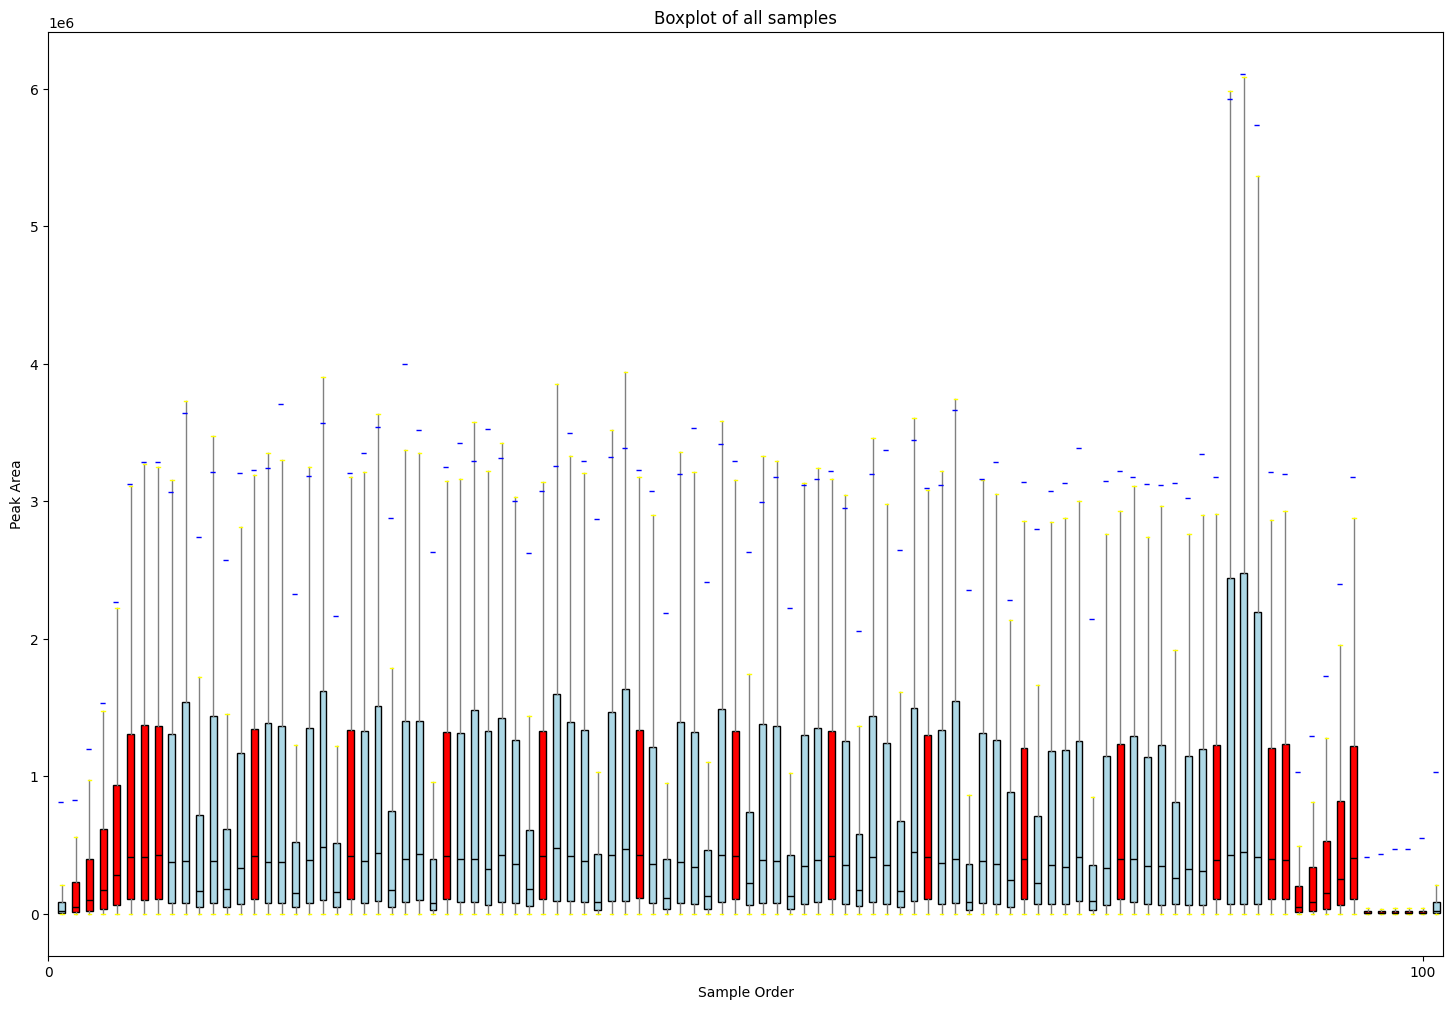

In [90]:
#filter our quality-control samples (QC)
QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist()
#print(QC_samples)
print(len(QC_samples))

#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
#print(is_qc_sample)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(18, 12))

# Create a box plot for the specific feature
box = plt.boxplot(data.iloc[:,1:], showfliers=False, showmeans=True, meanline=True, medianprops={'color':'black'}, meanprops={'color':'blue'}, patch_artist=True, whiskerprops=dict(color='grey'), capprops=dict(color='yellow'))
plt.title('Boxplot of all samples')

# Can depict if there is a problem with the data (retenion time shift too big -> re-run alignment; batch effect, etc.)

#Color boxplots of QC samples in red and the rest in blue
colors = ['red' if qc else 'lightblue' for qc in is_qc_sample]
# Set the colors for the individual boxplots
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize the plot
plt.xlabel('Sample Order')
plt.ylabel('Peak Area')
xx = np.arange(0, len(data.columns[1:])+1, 100)
plt.xticks(xx, xx)

# Save the plot
plt_name = main_folder + '/figures/QC_samples_boxplot_first_view'
for sufix in sufixes:
    plt.savefig(plt_name + sufix, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

#---------------------------------------------
#REPORTING
text0 = 'The initial visualization of the data was created.'
text1 = 'The boxplot of all samples was created and saved to: ' + plt_name
report.add_together([('text', text0),
                    ('text', text1),
                    ('image', plt_name + '.png'),
                    'line'])


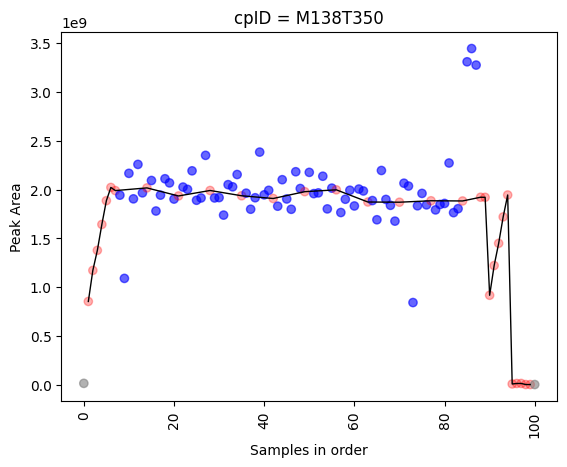

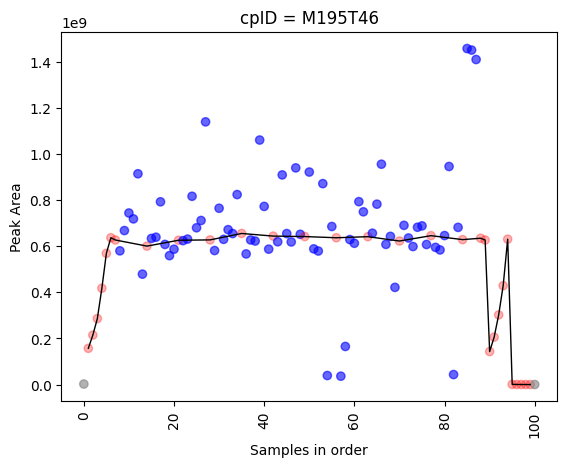

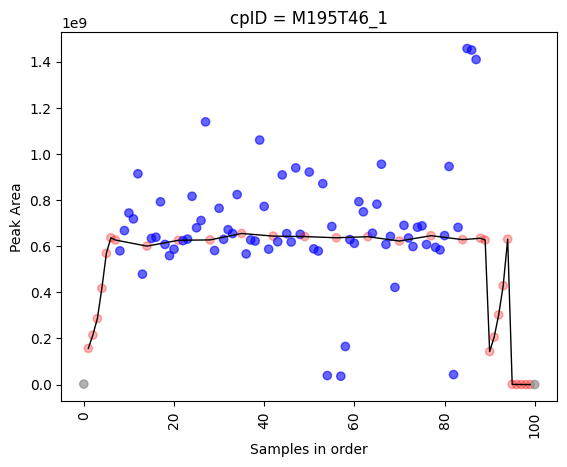

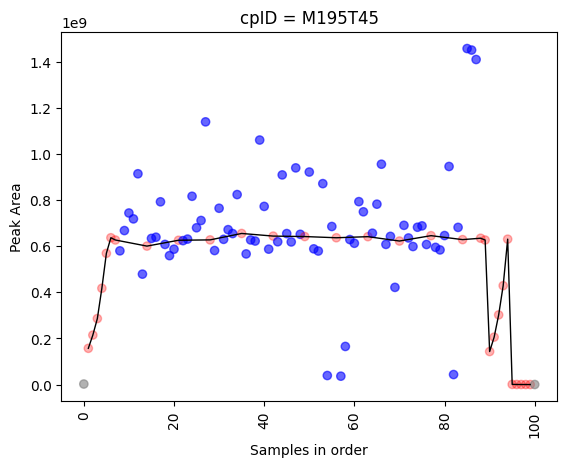

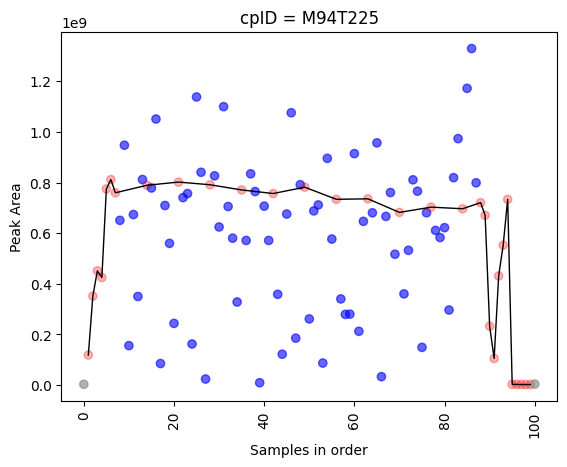

In [92]:
QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist()
# QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

blank_samples = metadata[metadata['Coffee Brand'] == 'Blank']['SampleFile'].tolist()
# Blank samples mask
is_blank = [True if col in blank_samples else False for col in data.columns[1:]]

# Create a boolean mask for the x array
x_mask = np.full(len(data.columns) - 1, False)
x_mask[is_qc_sample] = True

# Choose a compounds to plot
indexes = [0, 1, 2, 3, 4]
for index in indexes:
    colors = ['red' if qc else 'grey' if blank else 'blue' for blank, qc in zip(is_blank, is_qc_sample)]
    alphas = [0.3 if qc else 0.6 for qc in is_qc_sample]
    # Create a zero mask (for qc samples)
    zeros_mask = data.iloc[index, 1:][is_qc_sample] == 0
    #qc_num_zeros = zeros_mask.sum()
    #samples_num_zeros = (data.iloc[index, 1:] == 0).sum()
    
    # Create a scatter plot to display the QC sample points
    plt.scatter(range(len(data.columns) -1), data.iloc[index, 1:], color= colors, alpha=alphas, marker='o') 
    plt.plot(np.arange(len(data.columns) - 1)[x_mask][~zeros_mask], data.iloc[index, 1:][is_qc_sample][~zeros_mask], color='black', linewidth=1)
    plt.xticks(rotation=90)
    plt.xlabel('Samples in order')
    plt.ylabel('Peak Area')
    plt.title("cpID = " + data.iloc[index, 0])
    for sufix in sufixes:
        plt.savefig(main_folder + '/figures/single_compound_' + str(index) + '_scatter_first_view' + sufix, dpi=300, bbox_inches='tight')
    plt.show()

#---------------------------------------------
#REPORTING
text = 'View of samples for a single compound with highlighted QC samples was created.'
images = [main_folder + '/figures/single_compound_' + str(index) + '_scatter_first_view' for index in indexes]
report.add_text(text)
for image in images:
    report.add_image(image)
report.add_line()


### Batch visualization

C:\Users\janna\AppData\Local\Temp\ipykernel_10000\2847952326.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


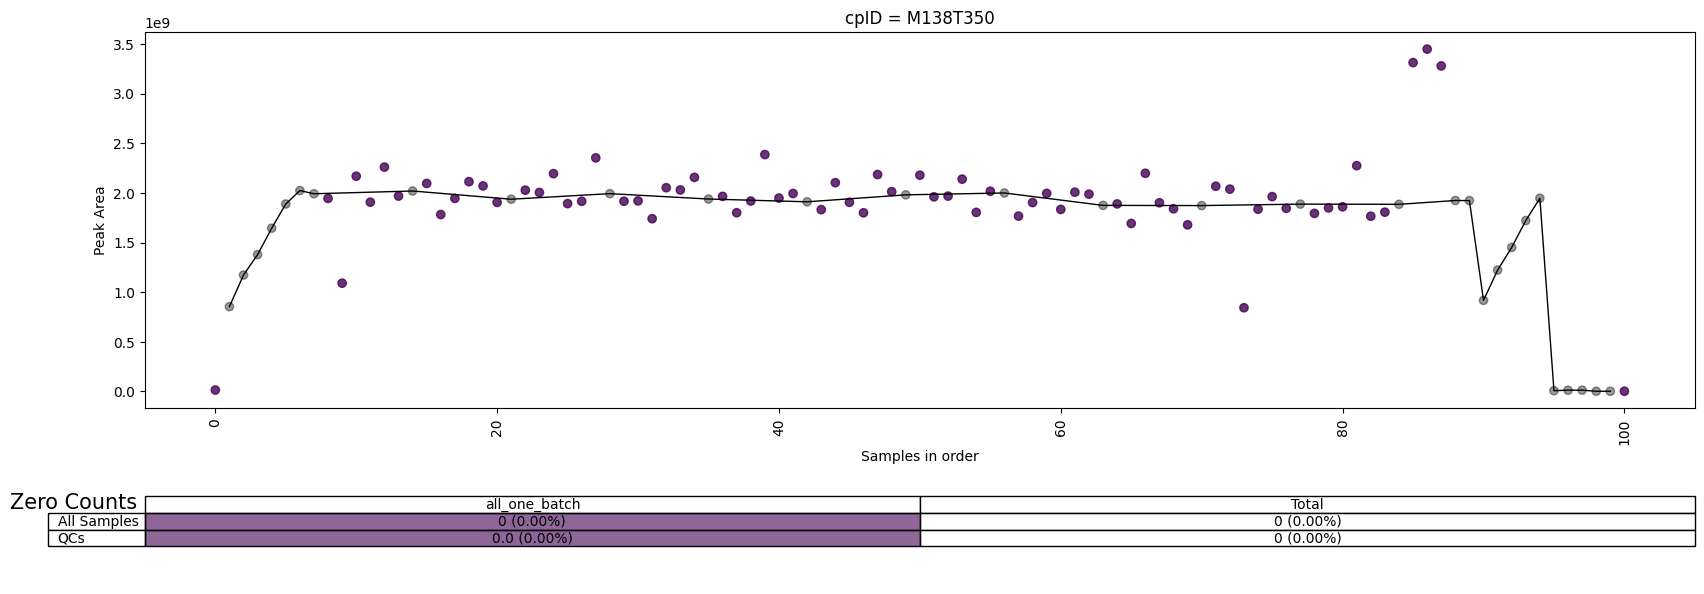

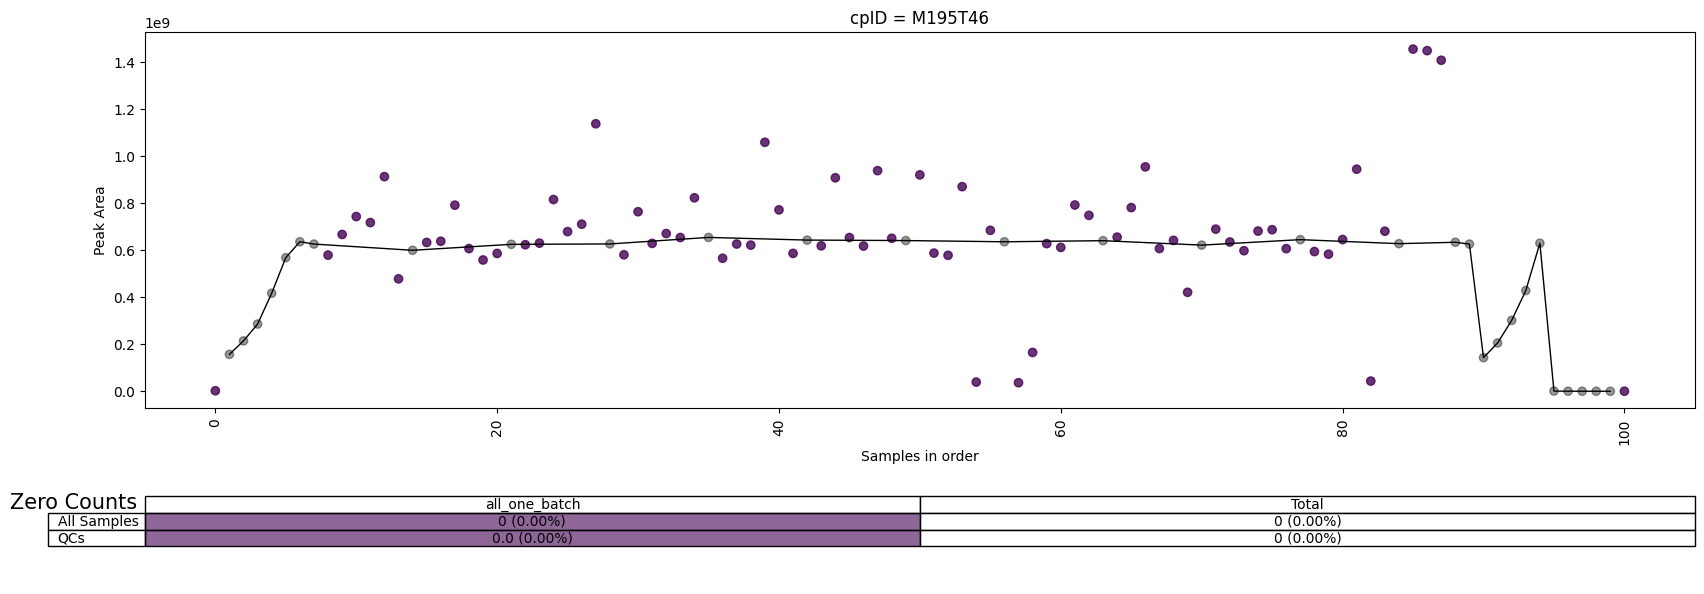

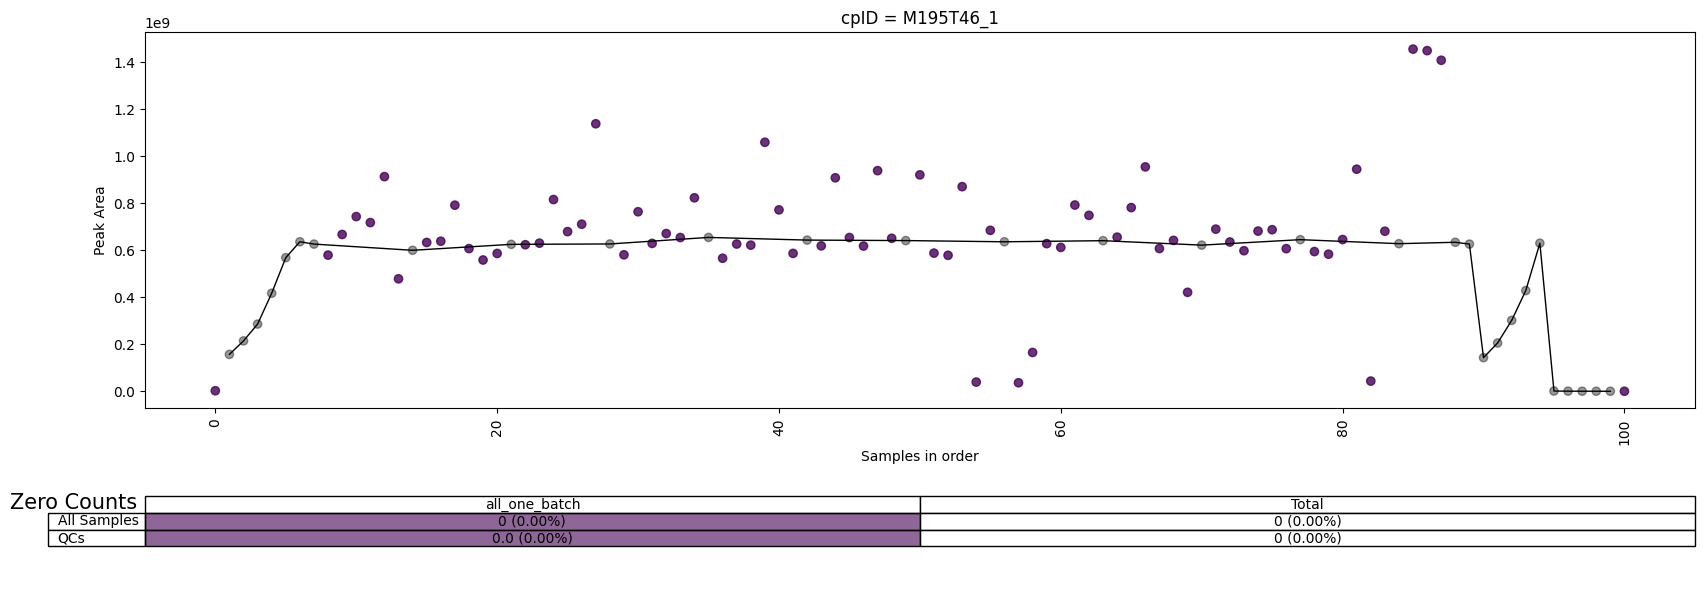

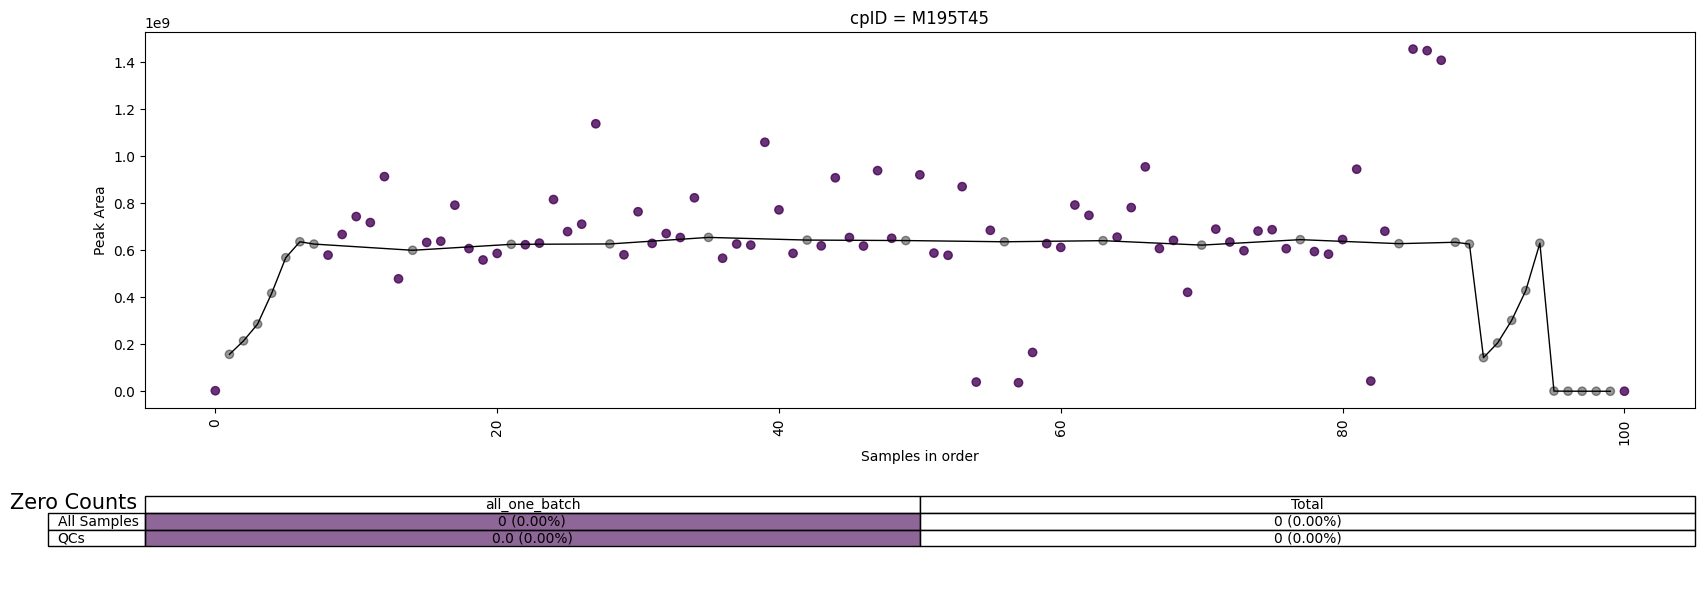

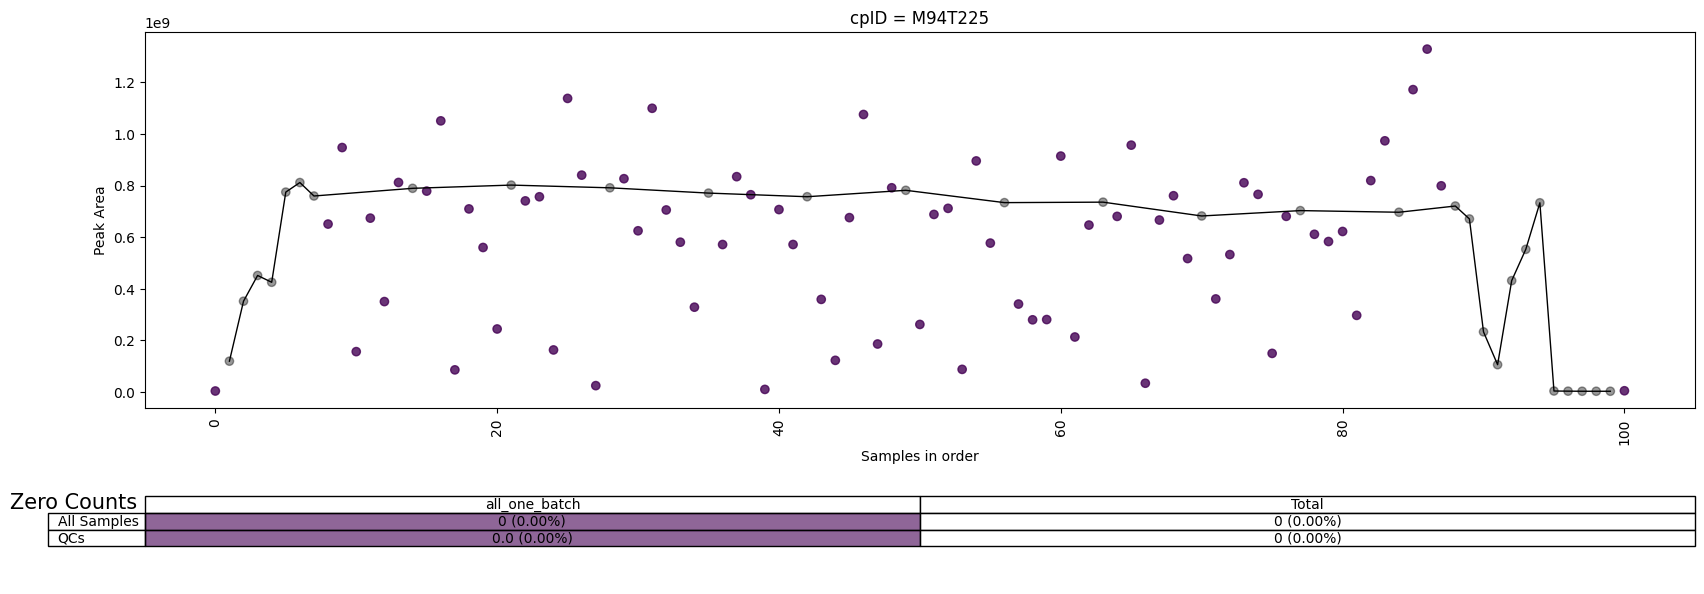

In [95]:
# Coloring batches

# Choose a compounds to plot
indexes = [0, 1, 2, 3, 4]

def visualize_by_batch(data, indexes, QC_samples, main_folder, sufixes, batch = None):

    if batch is None:
        batch = ['all_one_batch' for i in range(len(data.columns) - 1)]  # Dummy batch information (for cases where its all the same batch)

    unique_batches = []
    for b in batch:
        if b not in unique_batches:
            unique_batches.append(b)
    
    cmap = mpl.cm.get_cmap('viridis')

    # Create a dictionary that maps each unique batch to a unique index
    batch_to_index = {batch: index for index, batch in enumerate(unique_batches)}

    # Normalize the indices between 0 and 1
    normalized_indices = {batch: index / len(unique_batches) for batch, index in batch_to_index.items()}

    # Create a dictionary that maps each batch to a color
    batch_colors = [mpl.colors.rgb2hex(cmap(normalized_indices[batch])) for batch in unique_batches]

    batch_to_color = {batch_id: batch_colors[i % len(batch_colors)] for i, batch_id in enumerate(unique_batches)}


    # QC_samples mask
    is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
    # Create a boolean mask for the x array
    x_mask = np.full(len(data.columns) - 1, False)
    x_mask[is_qc_sample] = True

    # Color based on the batch (and if it is QC sample then always black)
    for index in indexes:

        # Colors and alphas and markers
        colors = ['black' if qc else batch_to_color[batch[i]] for i, qc in enumerate(is_qc_sample)]
        row_data = data.iloc[index, 1:]
        alphas = [0.4 if qc else 0.1 if zero else 0.8 for qc, zero in zip(is_qc_sample, row_data == 0)]
        #markers = ['x' if qc else 'x' if zero else 'o' for qc, zero in zip(is_qc_sample, row_data == 0)]
        # I NEED TO SCATTER TWICE TO DIFFERENTIATE QC AND SAMPLES (SCATTER DOESNT SUPPORT LIST OF MARKERS AS AN INPUT)

        # Create a zero mask (for qc samples)
        zeros_mask = data.iloc[index, 1:][is_qc_sample] == 0
        #qc_num_zeros = zeros_mask.sum()
        #samples_num_zeros = (data.iloc[index, 1:] == 0).sum()

        # Initialize a dictionary to store the zero counts for each batch
        zero_counts = {batch_id: 0 for batch_id in set(batch)}
        qc_zero_counts = {batch_id: 0 for batch_id in set(batch)}

        # Update the zero counts for each batch
        for i, is_zero in enumerate(data.iloc[index, 1:] == 0):
            if is_zero:
                zero_counts[batch[i]] += 1
                if is_qc_sample[i]:
                    qc_zero_counts[batch[i]] += 1

        # Create a gridspec object
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 3:1 height ratio

        # Create a figure with specified size
        fig = plt.figure(figsize=(20, 4)) 

        # Create a scatter plot to display the QC sample points
        plt.subplot(gs[0])
        plt.scatter(range(len(data.columns) -1), data.iloc[index, 1:], color= colors, alpha=alphas, marker='o') 
        plt.plot(np.arange(len(data.columns) - 1)[x_mask][~zeros_mask], data.iloc[index, 1:][is_qc_sample][~zeros_mask], color='black', linewidth=1)
        plt.xticks(rotation=90)
        plt.xlabel('Samples in order')
        plt.ylabel('Peak Area')
        plt.title("cpID = " + data.iloc[index, 0])

        # Create a table to display the zero counts
        plt.subplot(gs[1])
        plt.axis('tight')  # Remove axis
        plt.axis('off')  # Hide axis
        fig.subplots_adjust(bottom=-0.5) # Adjust the bottom of the figure to make room for the table

        # Calculate the total number of samples and QC samples for each batch
        total_samples = {batch_id: batch.count(batch_id) for batch_id in unique_batches}
        total_qc_samples = {batch_id: sum(1 for b, qc in zip(batch, is_qc_sample) if b == batch_id and qc) for batch_id in unique_batches}

        # Calculate the total number of QC samples
        total_qc_samples_count = sum(qc_zero_counts.values())
        total_qc_percentage = total_qc_samples_count / len(batch) * 100

        # Calculate the percentage of zeros for each batch
        #zero_percentages = [zero_count / total_samples[batch] * 100 for batch, zero_count in zip(batch, zero_counts.values())]
        zero_percentages = [zero_count / total_samples[batch] * 100 for batch, zero_count in zero_counts.items()]

        # Format the zero counts and percentages as strings
        formatted_zero_counts = [f"{zero_count} ({percentage:.2f}%)" for zero_count, percentage in zip(zero_counts.values(), zero_percentages)]

        # Calculate the QC zero counts for each batch and format them as strings
        qc_zero_counts = [qc_zero_count / total_qc_samples[batch] * 100 for batch, qc_zero_count in zip(batch, qc_zero_counts.values())]

        # Calculate the QC zero percentages
        qc_zero_percentages = [qc_zero_count / total_qc_samples[batch] * 100 for batch, qc_zero_count in zip(batch, qc_zero_counts)]

        # Format the QC zero counts and percentages as strings
        formatted_qc_zero_counts = [f"{qc_zero_count} ({percentage:.2f}%)" for qc_zero_count, percentage in zip(qc_zero_counts, qc_zero_percentages)]


        # Calculate the total number of missing values
        total_missing = sum(zero_counts.values()) 
        total_percentage = total_missing / len(batch) * 100
        
        # Append 'white' to the batch colors for the total
        table_batch_colors = batch_colors + ['white']

        # Append the total to the sorted lists
        col_labels = unique_batches + ['Total']

        # Append the total to the formatted zero counts
        formatted_zero_counts.append(f"{total_missing} ({total_percentage:.2f}%)")
        formatted_qc_zero_counts.append(f"{total_qc_samples_count} ({total_qc_percentage:.2f}%)")

        # Convert all colors in the list to RGBA format
        table_batch_colors_rgba = [convert_to_rgba(color, 0.6) for color in table_batch_colors]


        # Create the table as before
        plt.table(cellText=[formatted_zero_counts, formatted_qc_zero_counts],  # Sorted values of the table
            #cellColours=[table_batch_colors, table_batch_colors],
            cellColours=[table_batch_colors_rgba, table_batch_colors_rgba], # Sorted colors of the table
            rowLabels=['All Samples', 'QCs'],  # Row label
            colLabels=col_labels,  # Sorted column labels
            cellLoc='center',  # Alignment of the data in the table
            fontsize=10,  # Font size
            loc='center')  # Position of the table

        # Add a text annotation for "Zero Counts"
        plt.text(x=-0.005, y=0.65, s='Zero Counts', fontsize=15, transform=plt.gca().transAxes, ha='right', va='center')

        plt_name = main_folder + '/figures/single_compound_' + str(index) + '_batches_first_view'
        for sufix in sufixes:
            plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
        plt.show()

    #---------------------------------------------
    #REPORTING
    text = 'View of samples for a single compound with highlighted QC samples was created.'
    report.add_text(text)
    #add plot to the report
    images = [main_folder + '/figures/single_compound_' + str(index) + '_batches_first_view' for index in indexes]
    for index in indexes:
        report.add_image(images[index])
    report.add_pagebreak()


def convert_to_rgba(color, alpha=0.5):
    rgb = mcolors.hex2color(color)  # Convert hexadecimal to RGB
    return rgb + (alpha,)  # Concatenate RGB with alpha


# # Get batch information
# batch = batch_info['Batch'].tolist()
# batch = [value for value in batch if value is not None]

# or 
batch = None # All samples in one batch

visualize_by_batch(data, indexes, QC_samples, main_folder, sufixes, batch) 

In [ ]:
# Dropping columns to omit them from analysis (specifically for this dataset)

print(data.shape)
# Dropping blank samples (first and last)
first_blank_values = data.iloc[:, 1]
data = data.drop(data.columns[1], axis=1)
last_blank_values = data.iloc[:, -1]
data = data.drop(data.columns[-1], axis=1)
print(data.shape)

#Dropping first 5 (QC) samples
data = data.drop(data.columns[1:6], axis=1)
print(data.shape)

#Dropping last 10 (QC) samples
data = data.drop(data.columns[-10:], axis=1)
print(data.shape)


#---------------------------------------------
#REPORTING
text0 = 'Blank samples were removed'
text1 = 'First 5 and last 10 QC samples were removed. (dQC)'
report.add_together([('text', text0), 
                     ('text', text1), 
                     'line'])

(6131, 102)
(6131, 100)
(6131, 95)
(6131, 85)


### Blank filtering MOVED UP HERE (LOG MADE A MESS, NEED TO CONSIDER WHERE TO DO THIS)

##### Also it is important to do this by batch

In [ ]:
#Blank filtering (intensity sample/blank = 20/1)
#filter out features (compounds) with intensity sample/blank < 20/1
# filters features by comparing the median intensity of blank samples to the median intensity of samples. Features where the relative intensity (fold change) is not large when compared to the blank are removed.
blank_threshold = 20

#filter our blank samples
#Blank_samples = metadata[metadata['SampleType'] == 'Blank']['SampleFile'].tolist()
#QC_samples = metadata[metadata['SampleType'] == 'QC']['SampleFile'].tolist()
#Blank_samples mask
#is_blank_sample = [True if col in Blank_samples else False for col in data.columns[1:]]
#QC_samples mask
#is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

# Specifically here:
blanks = pd.DataFrame() #saved into these variables before deleting from dataset
#different ways of to chose the threshold: median, min, max, first and last values
blanks['median'] = blanks.median(axis = 1)
blanks['min'] = blanks.min(axis = 1)
blanks['first'] = first_blank_values
blanks['last'] = last_blank_values


#Calculate intensity sample/blank DELETE THIS AFTER IT IS ALL IN A FUNCTION
#intensity_sample_blank = data[data.columns[1:][is_qc_sample]].median(axis=1)/data[data.columns[1:][is_blank_sample]].median(axis=1)
def calculate_intensity_sample_blank(data, blanks, setting = 'first'):
    return data.iloc[:, 1:].median(axis=1)/blanks[setting]


intensity_sample_blank = calculate_intensity_sample_blank(data, blanks, setting = 'first')

 #Filter out features (compounds) with intensity sample/blank < blank_threshold
data = data[intensity_sample_blank >= blank_threshold]
#reset index
data = data.reset_index(drop=True)

#report how many features were removed
print("Number of features removed: " + str(len(intensity_sample_blank[intensity_sample_blank < blank_threshold])) + " ;being: " + str(intensity_sample_blank[intensity_sample_blank < blank_threshold].index.tolist()))

#---------------------------------------------
#REPORTING
text0 = 'Features with intensity sample/blank < ' + str(blank_threshold) + ' were removed.'
text1 = 'Number of features removed: ' + str(len(intensity_sample_blank[intensity_sample_blank < blank_threshold])) + ' ;being: '+ str(intensity_sample_blank[intensity_sample_blank < blank_threshold].index.tolist()[:10])[:-1] + ', ...'
report.add_together([('text', text0),
                    ('text', text1),
                    'line'])

Number of features removed: 3642 ;being: [10, 15, 16, 20, 21, 26, 27, 28, 29, 35, 36, 39, 42, 45, 46, 48, 49, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 69, 70, 73, 74, 77, 79, 87, 88, 92, 94, 100, 101, 105, 106, 107, 109, 110, 113, 120, 122, 123, 124, 125, 126, 131, 132, 133, 137, 138, 146, 154, 156, 168, 173, 185, 192, 193, 195, 197, 198, 203, 204, 212, 214, 215, 217, 222, 224, 226, 231, 235, 236, 250, 251, 254, 255, 256, 257, 259, 264, 267, 268, 274, 280, 281, 282, 291, 295, 299, 310, 312, 316, 318, 322, 324, 326, 330, 332, 333, 337, 340, 346, 347, 349, 350, 352, 357, 361, 362, 364, 367, 384, 386, 387, 392, 395, 397, 398, 402, 403, 404, 405, 407, 409, 412, 415, 416, 417, 418, 419, 420, 423, 427, 432, 433, 444, 448, 449, 450, 451, 452, 455, 457, 463, 466, 467, 468, 469, 473, 475, 476, 479, 480, 488, 489, 490, 492, 493, 494, 495, 496, 503, 506, 509, 511, 513, 514, 516, 517, 521, 523, 530, 531, 532, 535, 537, 539, 544, 545, 546, 547, 548, 550, 557, 558, 559, 561, 567, 568, 571, 572, 5

In [ ]:
blanks

,median,min,first,last
0,NaN,NaN,1.441664e+07,2.250933e+06
1,NaN,NaN,2.554504e+06,4.652319e+05
2,NaN,NaN,2.554504e+06,4.652319e+05
3,NaN,NaN,2.554504e+06,4.652319e+05
4,NaN,NaN,3.206810e+06,4.143978e+06
...,...,...,...,...
6126,NaN,NaN,2.945506e+03,2.346567e+03
6127,NaN,NaN,2.324363e+03,1.920055e+03
6128,NaN,NaN,7.158947e+03,1.176314e+04
6129,NaN,NaN,6.590478e+03,1.082906e+04


In [ ]:
data

,cpdID,Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),Area: B_K_02_R_POS.raw (F2),Area: C_Ol_02_N_POS.raw (F11),Area: KR_K_01_R_POS.raw (F72),Area: KE_Ol_01_N_POS.raw (F66),Area: G_K_03_R_POS.raw (F53),Area: QC13_POS.raw (F99),...,Area: H_Ol_01_R_POS.raw (F58),Area: H_Ol_03_N_POS.raw (F61),Area: Bez_Op_02_R_POS.raw (F5),Area: KU_Op_01_R_POS.raw (F81),Area: QC23_POS.raw (F109),Area: ES_01_POS.raw (F42),Area: ES_02_POS.raw (F43),Area: ES_03_POS.raw (F44),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111)
0,M138T350,2.023172e+09,1.990985e+09,1.943874e+09,1.090622e+09,2.167793e+09,1.906231e+09,2.259464e+09,1.967668e+09,2.018490e+09,...,1.859224e+09,2.273825e+09,1.764705e+09,1.805280e+09,1.884527e+09,3.311505e+09,3.447336e+09,3.277868e+09,1.922914e+09,1.921854e+09
1,M195T46,6.364744e+08,6.266685e+08,5.796860e+08,6.675881e+08,7.436873e+08,7.181689e+08,9.136959e+08,4.787771e+08,6.002250e+08,...,6.459475e+08,9.452678e+08,4.365491e+07,6.813733e+08,6.283718e+08,1.456315e+09,1.449782e+09,1.408845e+09,6.343736e+08,6.265968e+08
2,M195T46_1,6.364744e+08,6.266685e+08,5.796860e+08,6.675881e+08,7.436873e+08,7.181689e+08,9.136959e+08,4.787771e+08,6.002250e+08,...,6.459475e+08,9.452678e+08,4.365491e+07,6.813733e+08,6.283718e+08,1.456315e+09,1.449782e+09,1.408845e+09,6.343736e+08,6.265968e+08
3,M195T45,6.364744e+08,6.266685e+08,5.796860e+08,6.675881e+08,7.436873e+08,7.181689e+08,9.136959e+08,4.787771e+08,6.002250e+08,...,6.459475e+08,9.452678e+08,4.365491e+07,6.813733e+08,6.283718e+08,1.456315e+09,1.449782e+09,1.408845e+09,6.343736e+08,6.265968e+08
4,M94T225,8.116503e+08,7.594620e+08,6.506121e+08,9.473518e+08,1.559049e+08,6.736190e+08,3.499942e+08,8.119051e+08,7.892213e+08,...,6.218511e+08,2.965749e+08,8.192569e+08,9.734199e+08,6.964396e+08,1.171984e+09,1.329087e+09,7.989244e+08,7.205760e+08,6.704668e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,M222T314,6.942212e+04,8.126953e+04,1.098859e+05,7.973481e+04,5.019997e+03,1.273157e+05,8.434914e+03,9.585511e+04,8.045104e+04,...,9.144096e+04,1.900341e+04,7.443724e+04,7.537714e+04,7.086049e+04,1.554892e+05,1.816426e+05,1.732339e+05,6.639379e+04,6.248068e+04
2485,M363T312,9.179119e+04,7.479215e+04,1.212003e+05,7.312842e+04,3.294169e+03,1.082614e+05,2.013185e+04,1.723933e+05,7.754622e+04,...,6.339978e+04,4.816433e+03,6.404199e+04,5.563338e+04,7.112522e+04,9.900026e+04,1.540205e+05,9.552518e+04,4.711508e+04,6.249477e+04
2486,M303T340,7.920865e+04,1.186703e+05,1.347649e+05,1.157716e+05,8.839869e+04,9.482887e+04,1.563557e+05,8.753426e+04,1.161073e+05,...,6.311518e+04,2.261660e+04,8.916807e+03,3.311383e+04,1.677477e+04,1.993529e+04,1.842836e+04,1.660825e+04,6.728558e+04,5.544684e+04
2487,M264T311,1.629522e+05,9.700726e+04,1.058867e+05,8.319093e+04,6.724186e+03,7.418995e+04,1.348942e+04,1.432659e+05,8.004483e+04,...,5.948244e+04,5.131585e+03,3.153249e+04,5.129230e+04,5.769624e+04,1.482029e+04,4.753922e+04,6.418896e+04,6.103731e+04,6.330437e+04


### QC and Batch corrections

8.708497377870819
19.29150262212918


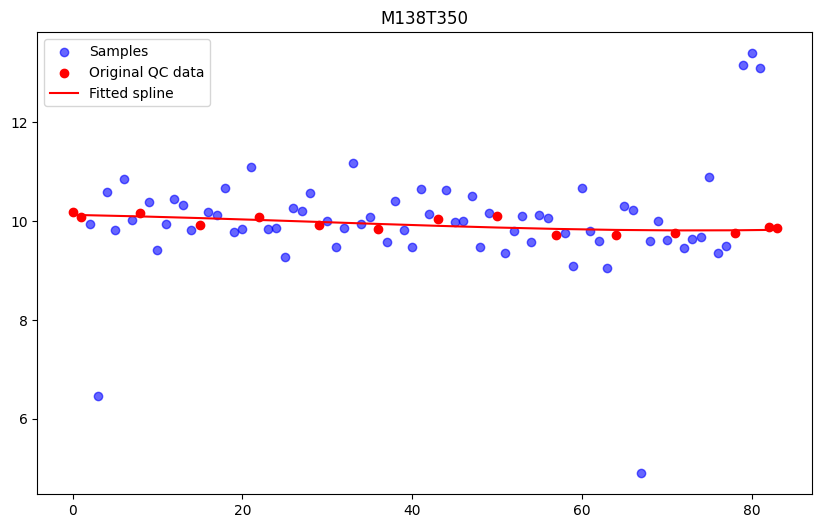

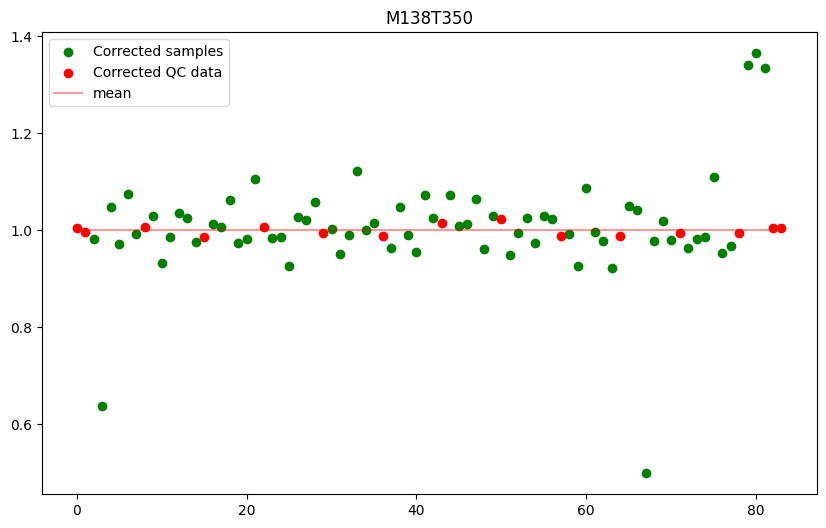

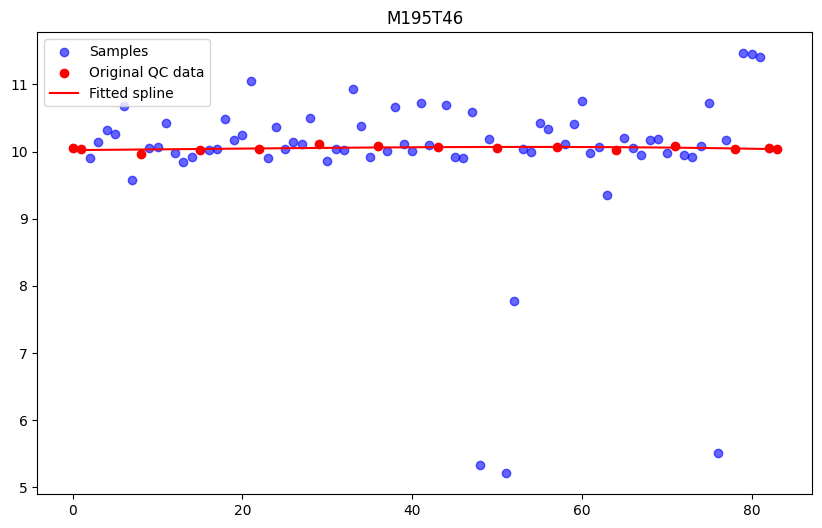

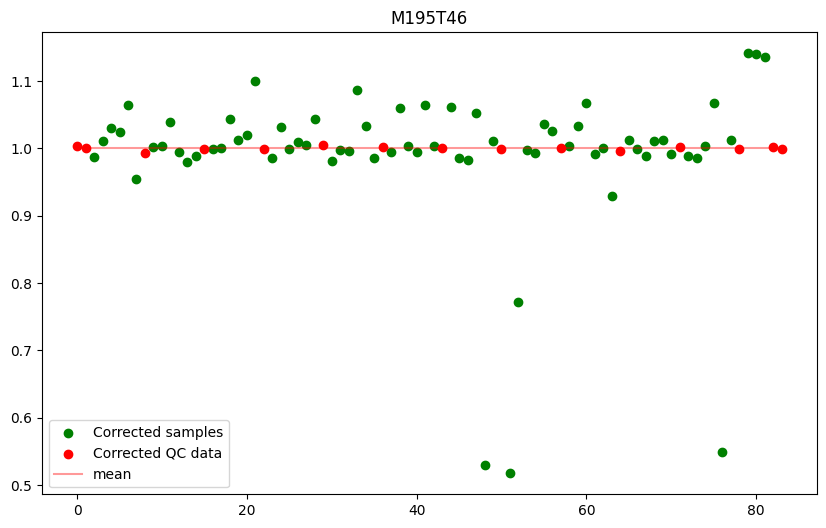

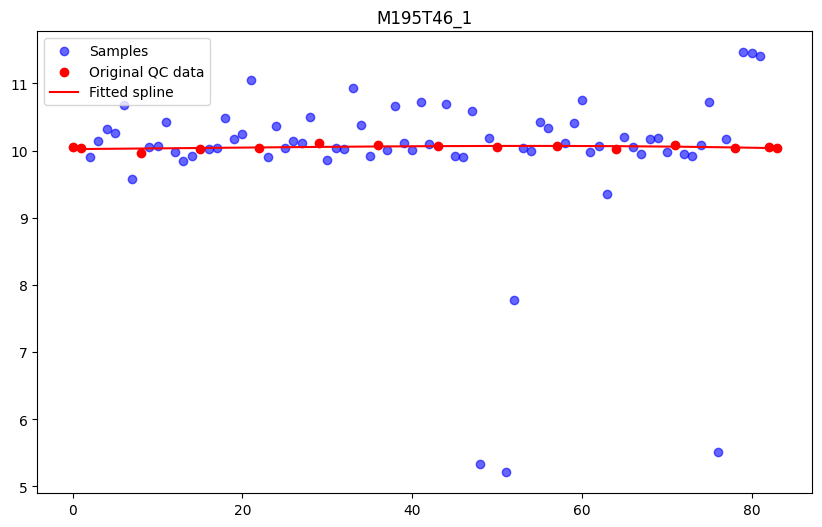

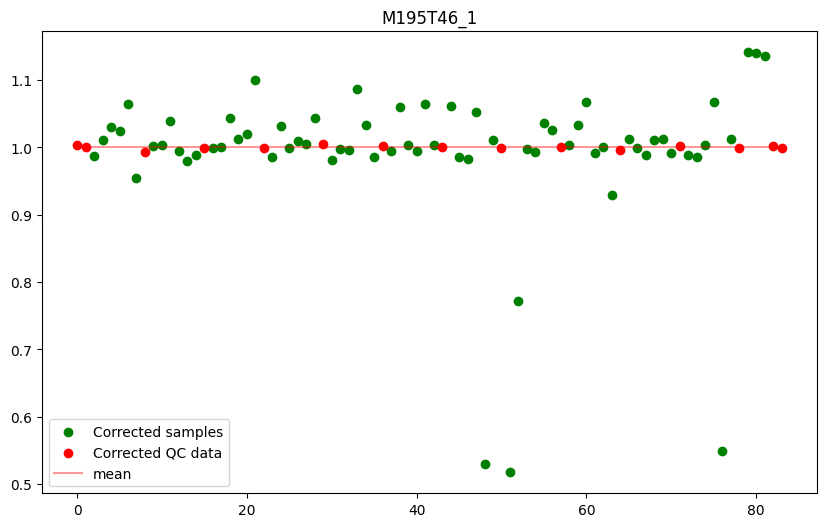

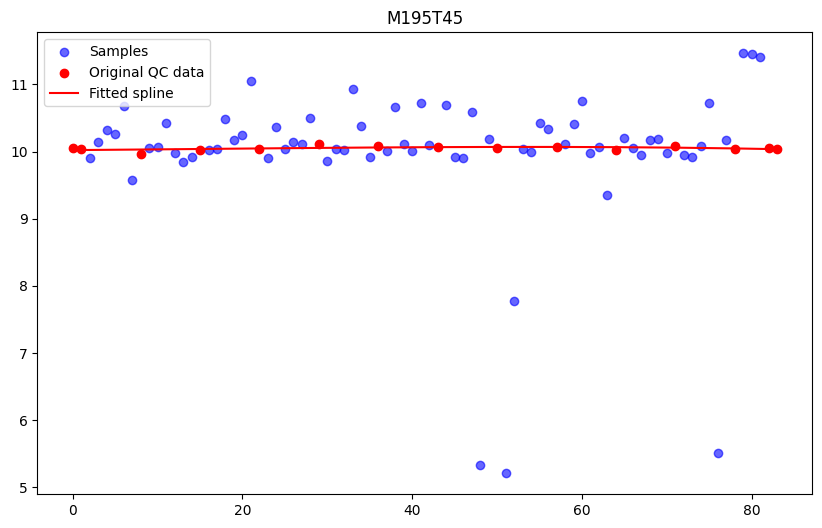

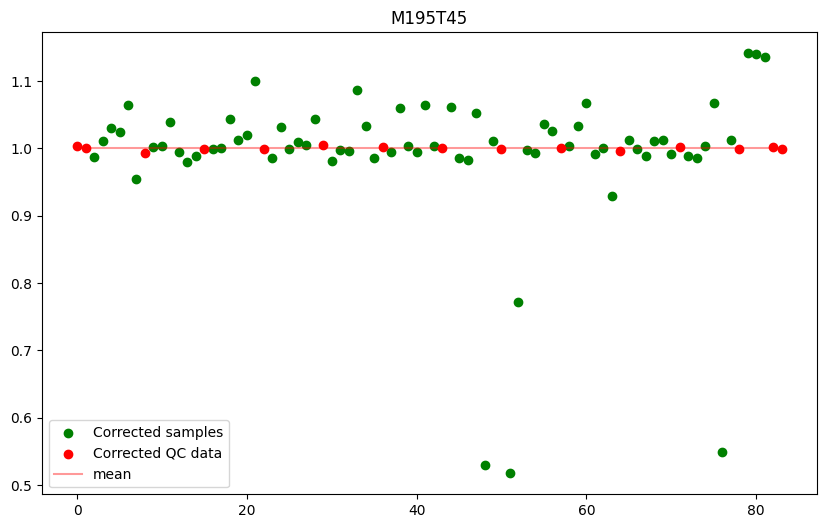

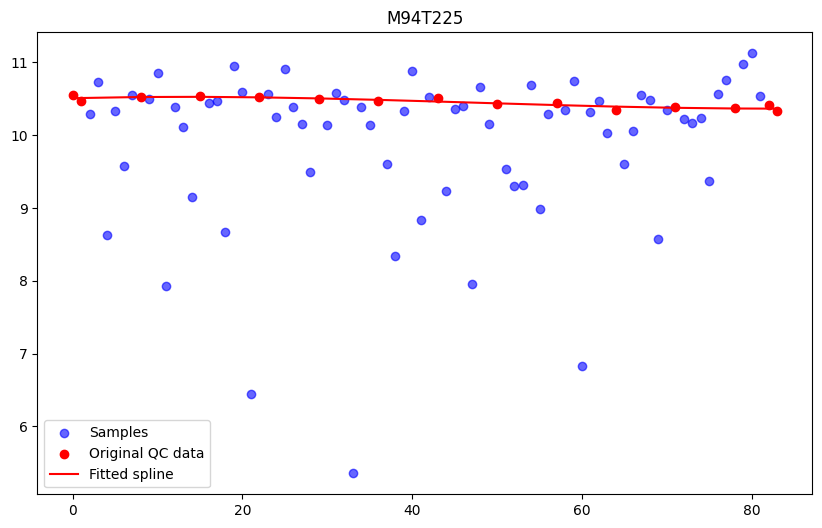

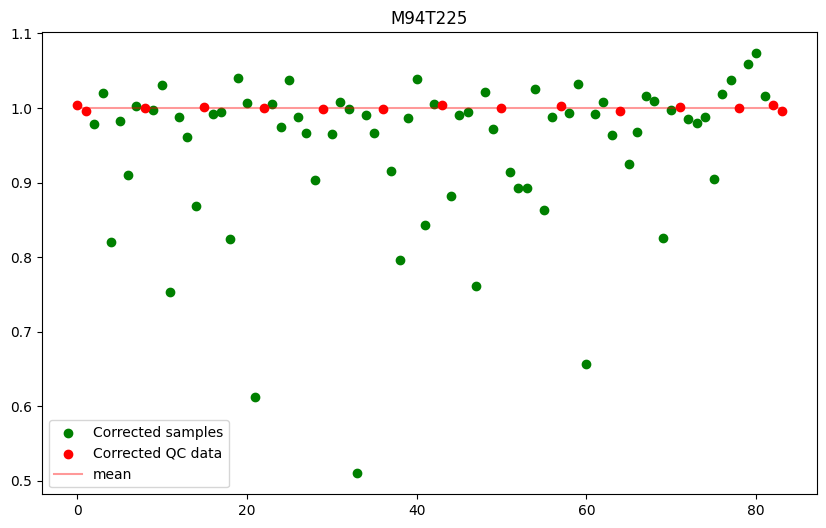

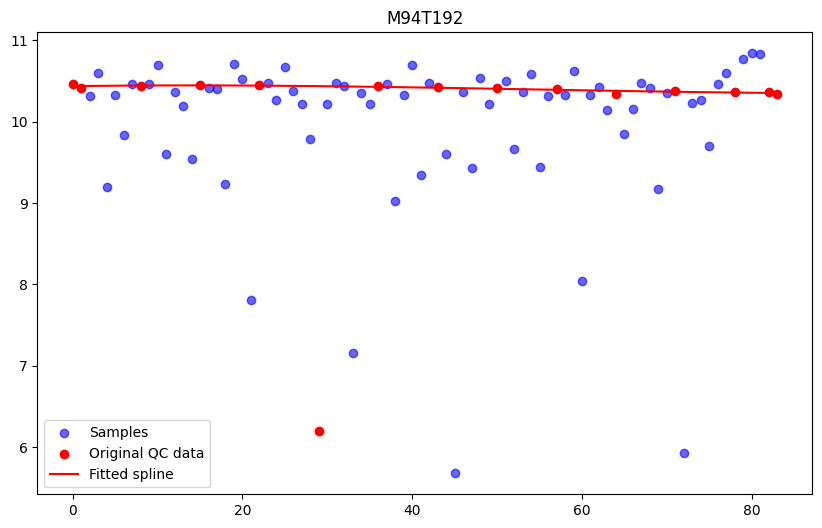

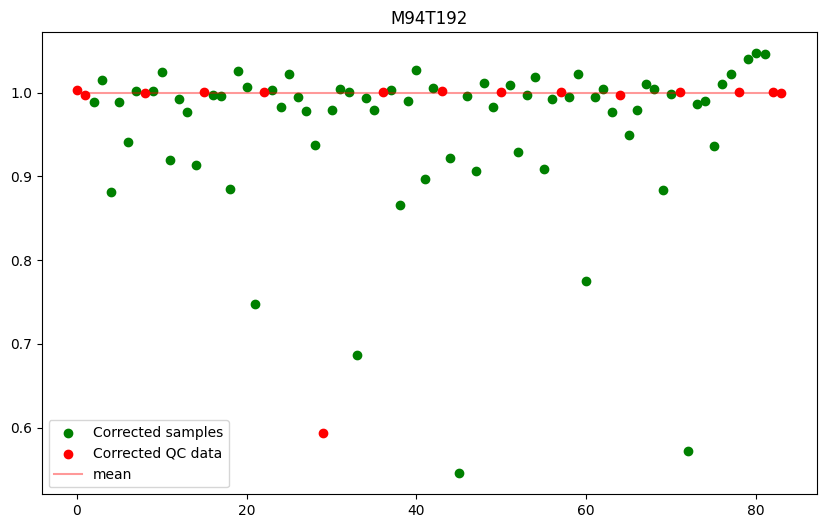

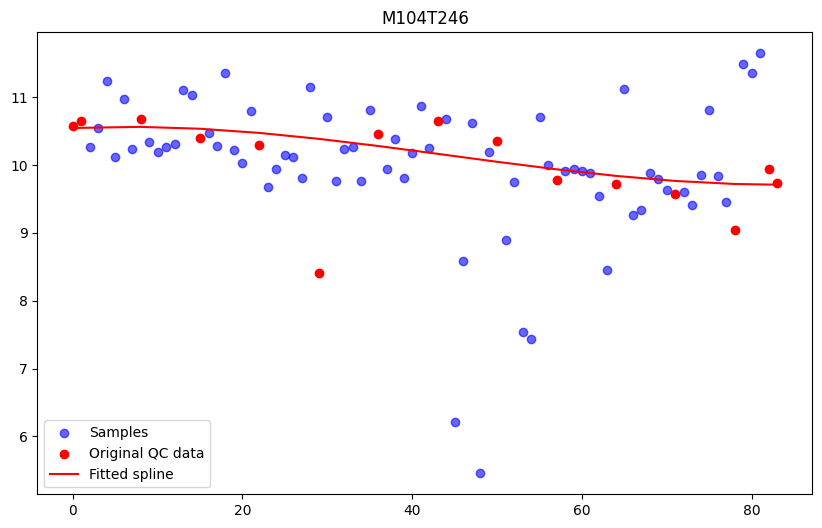

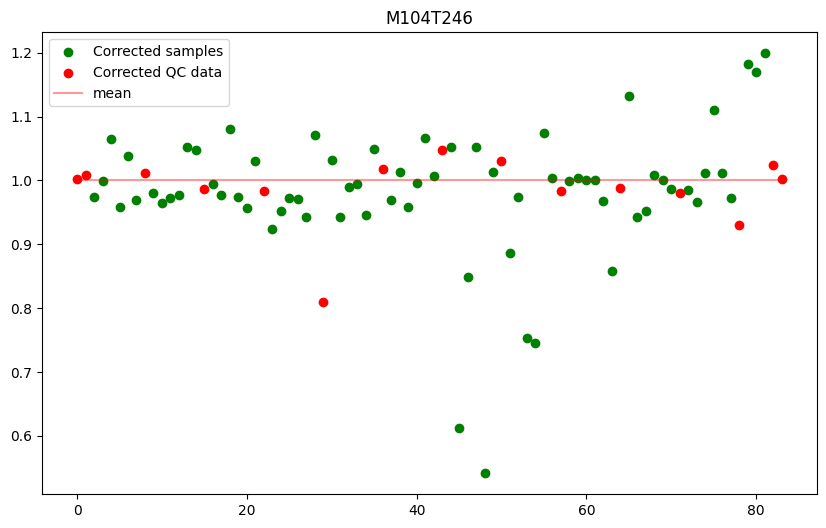

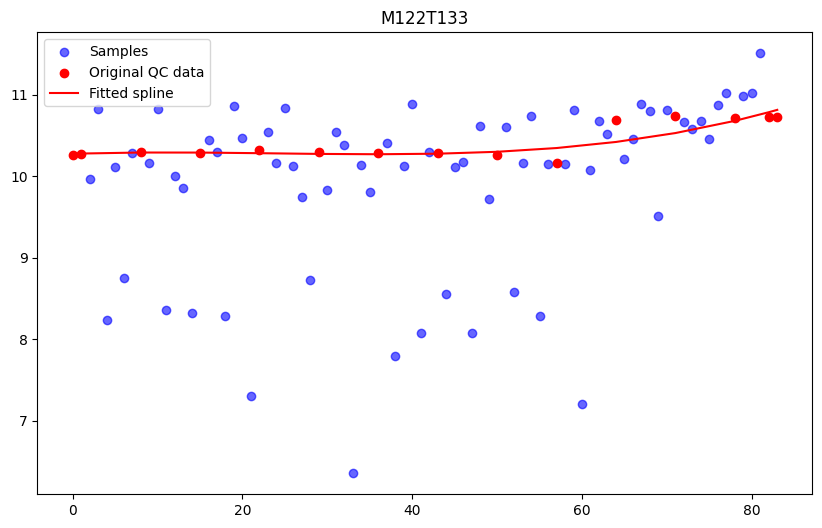

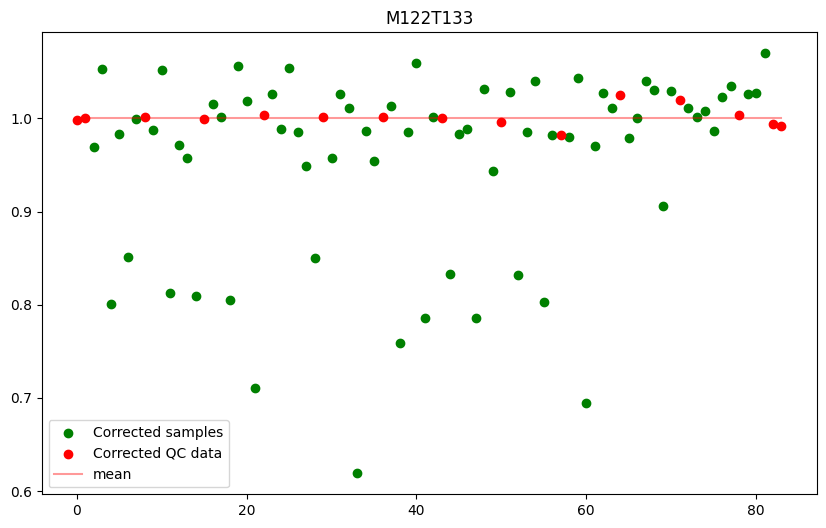

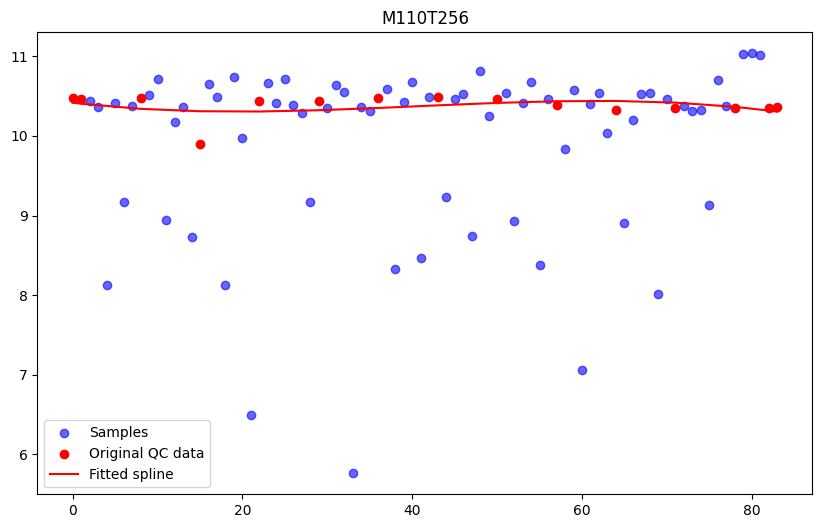

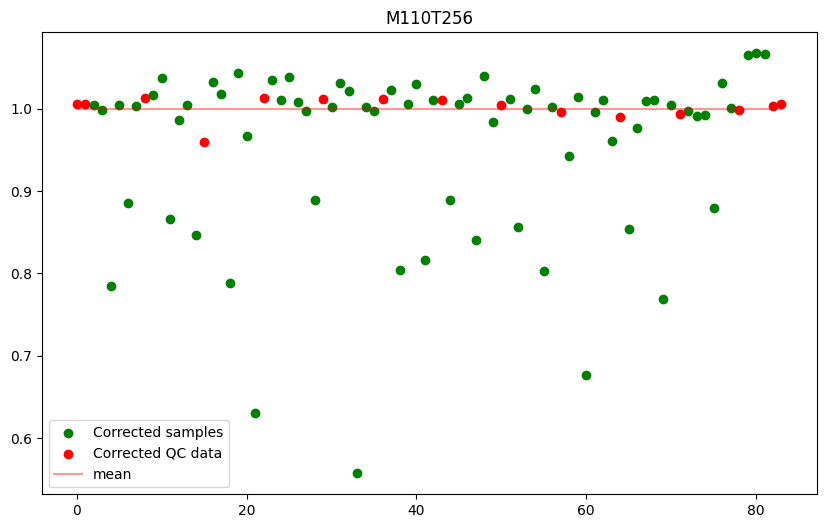

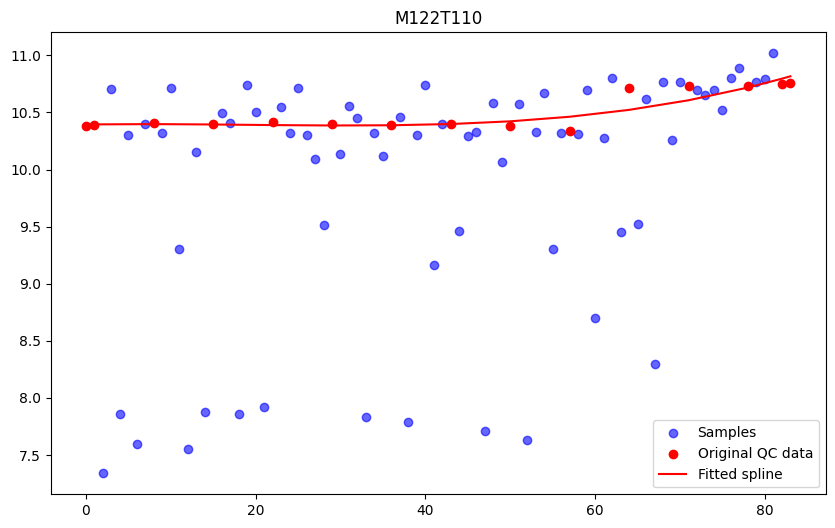

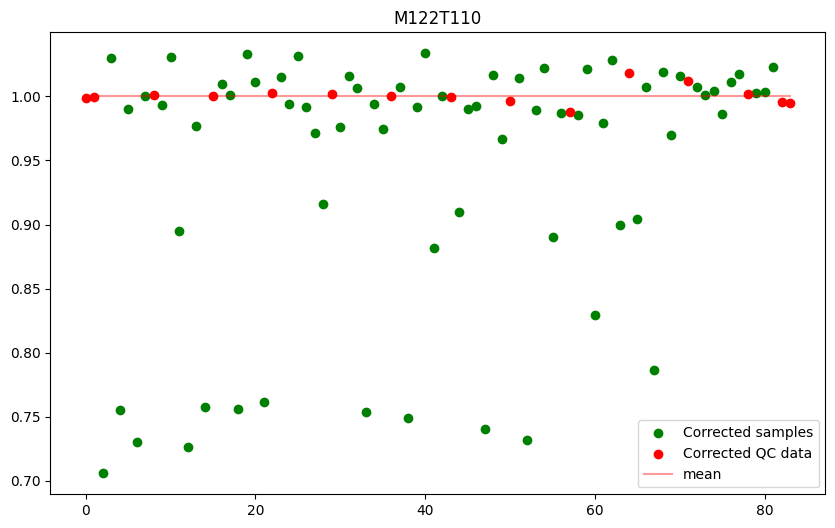

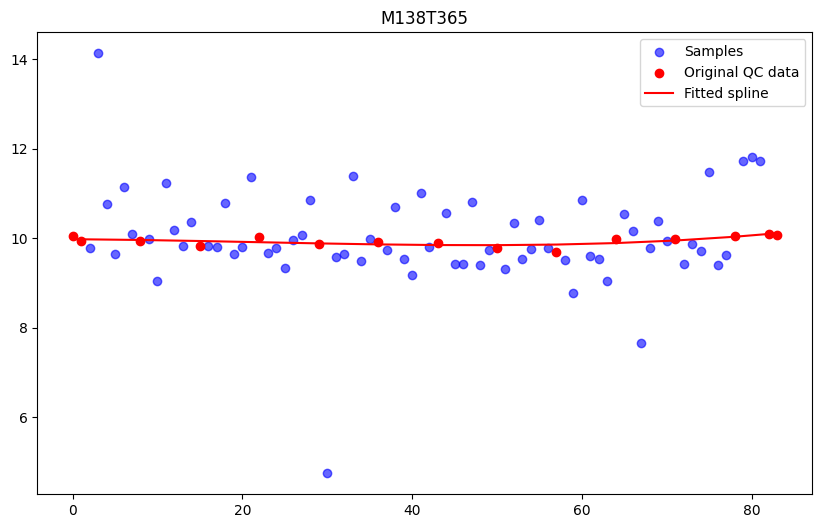

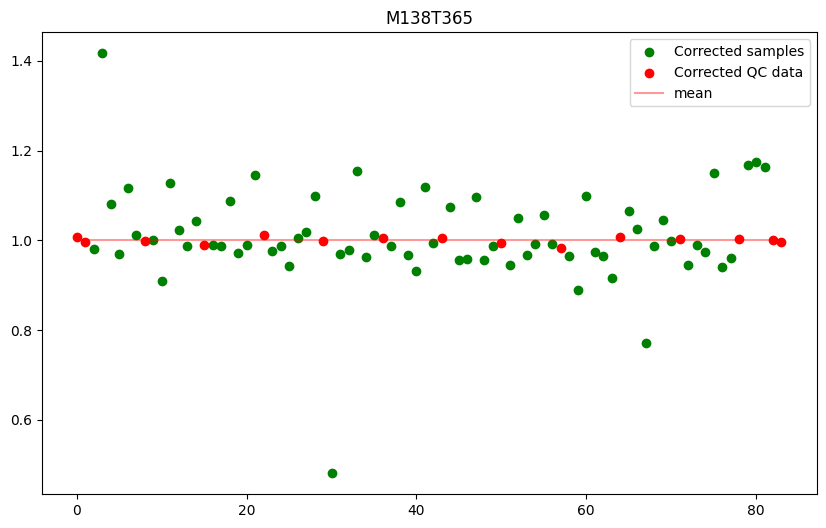

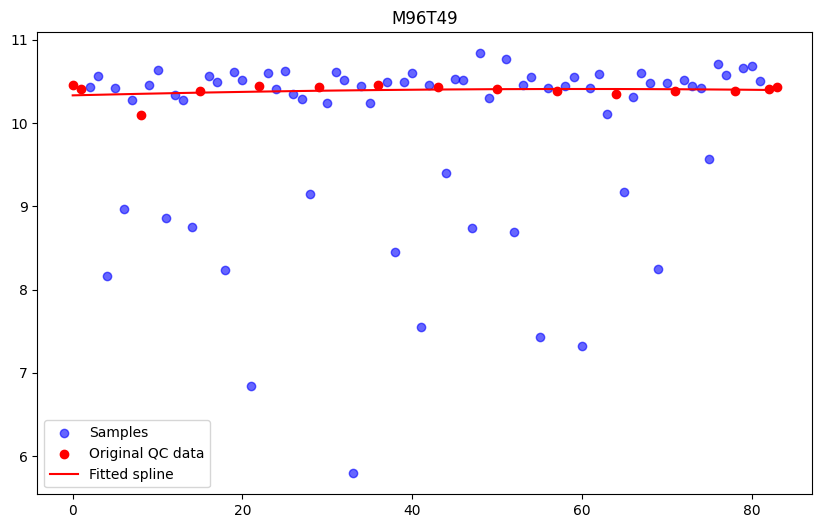

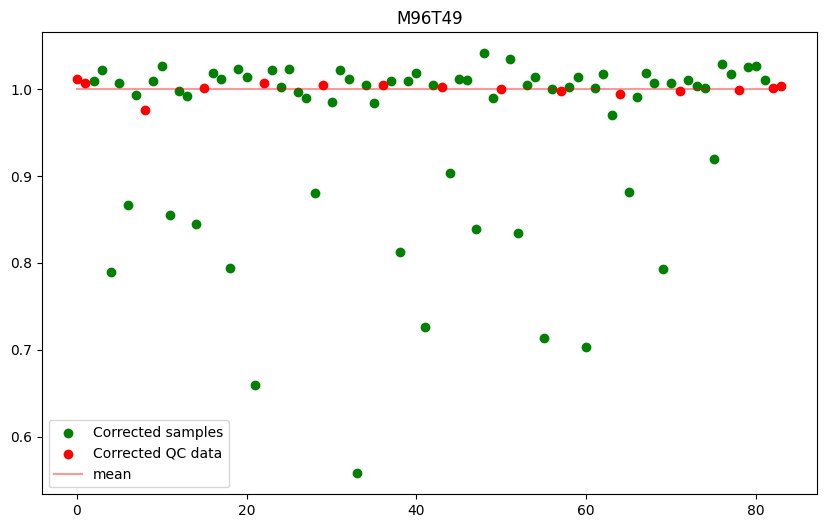

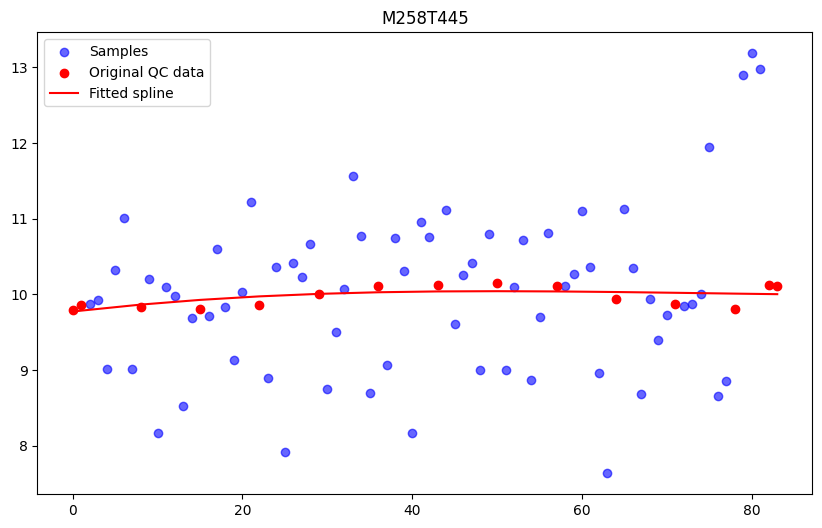

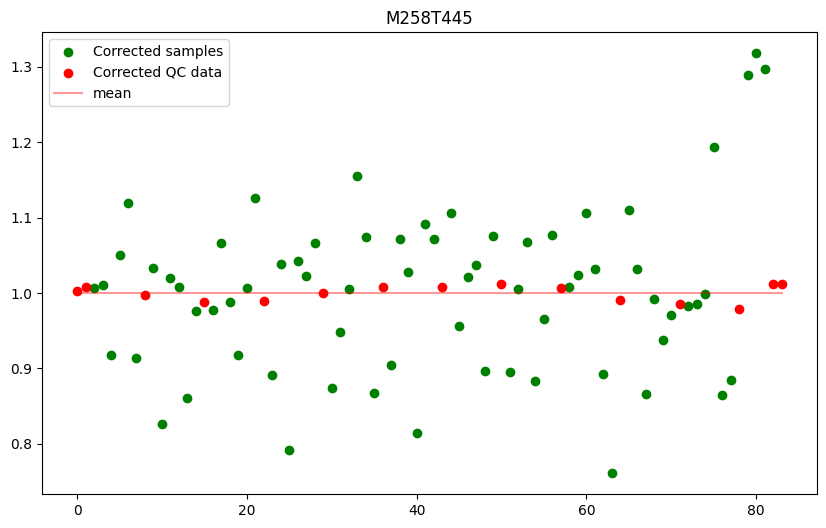

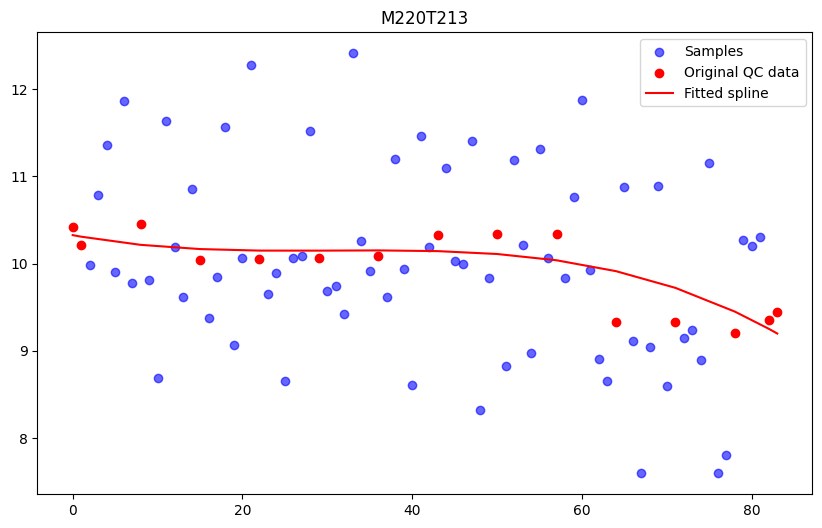

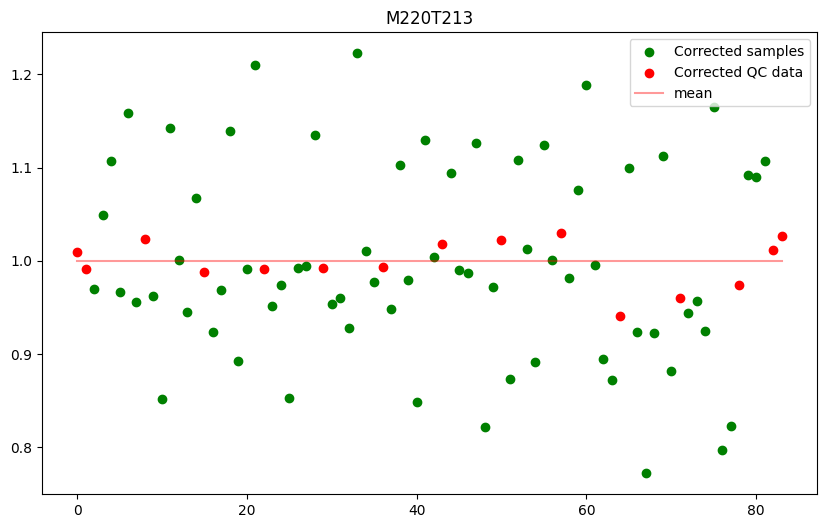

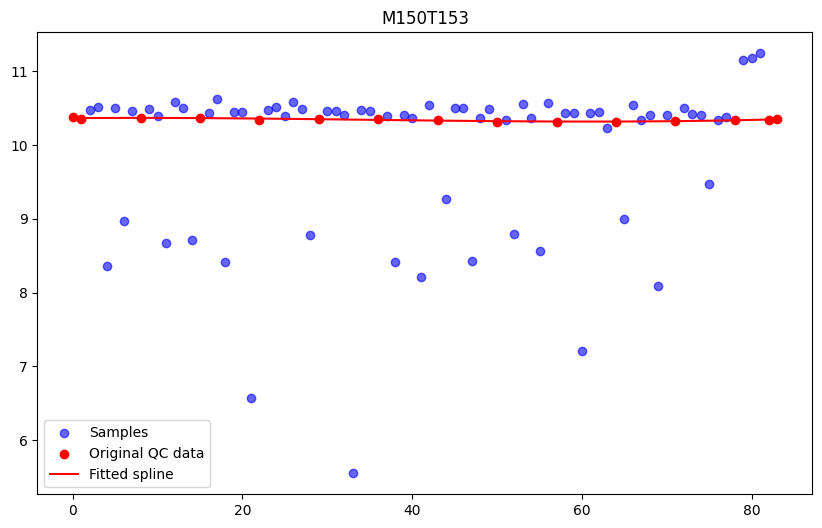

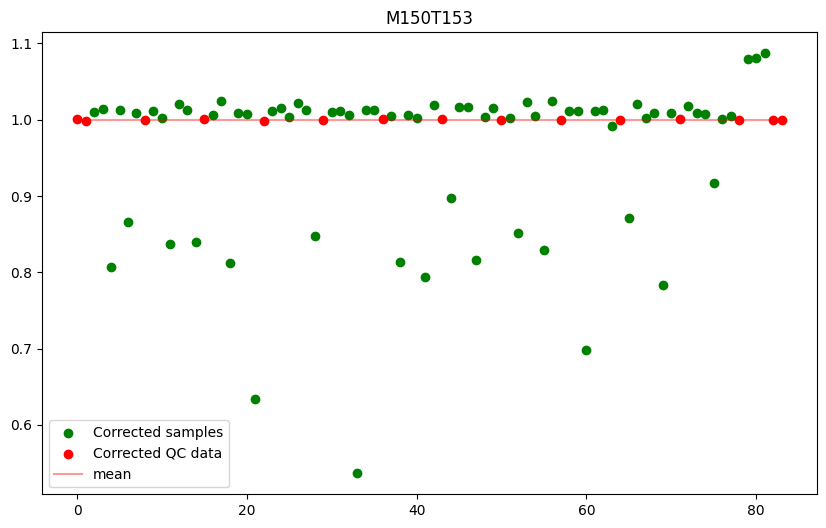

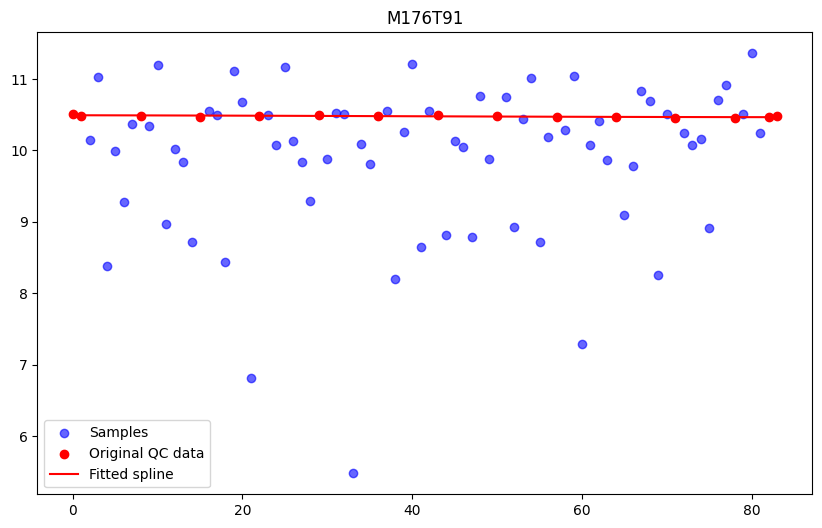

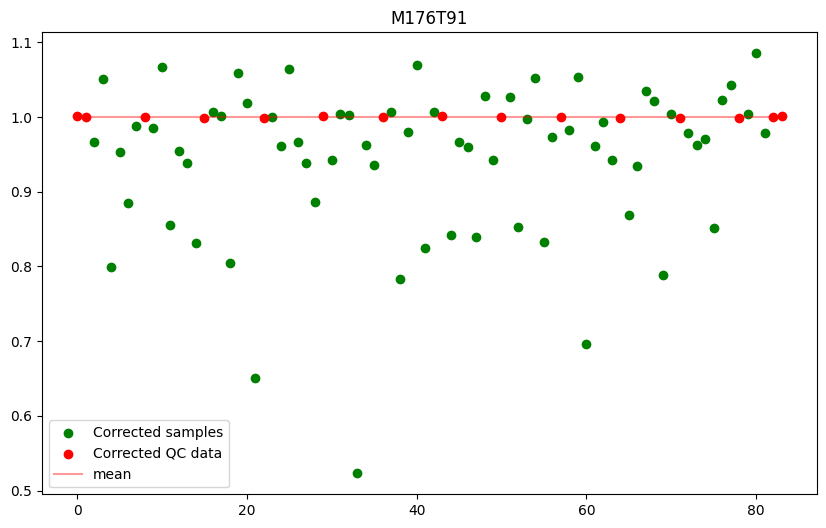

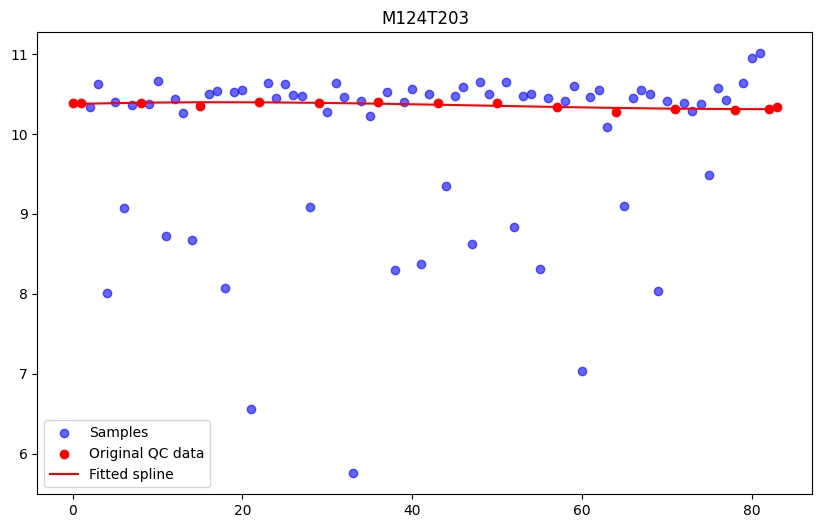

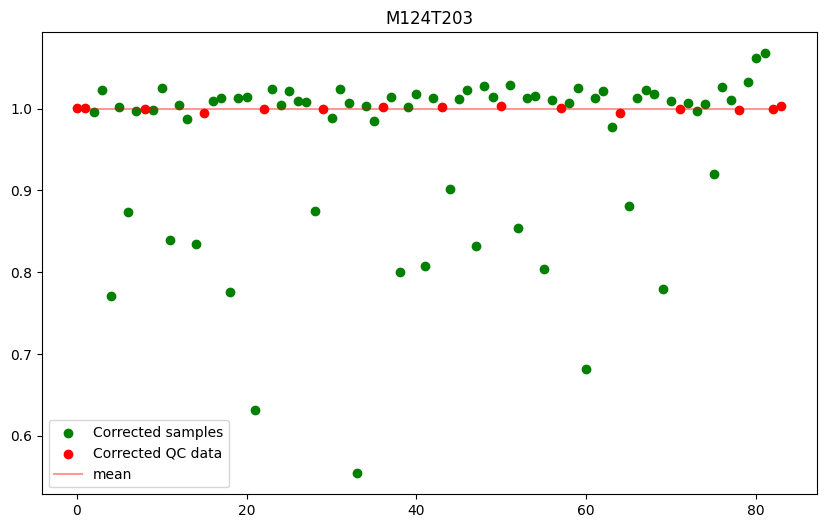

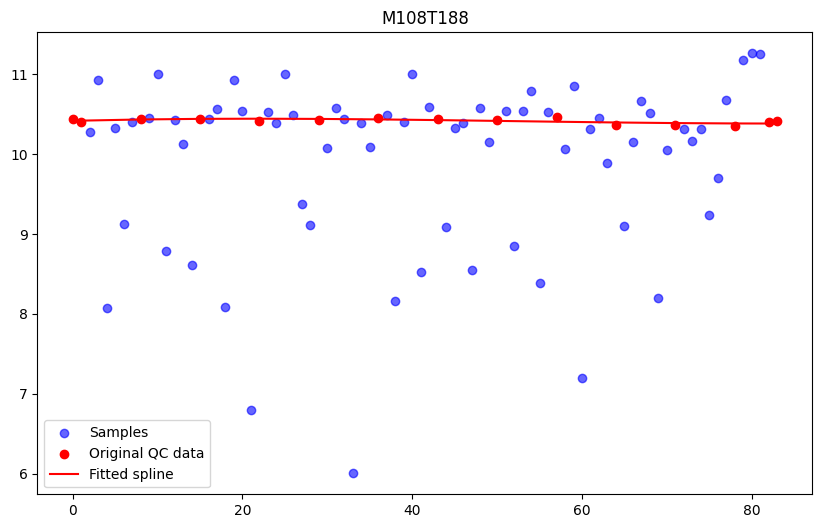

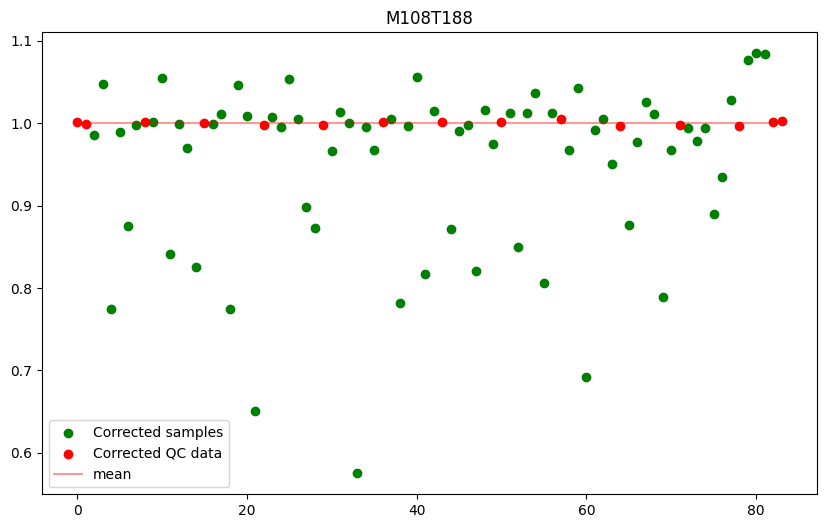

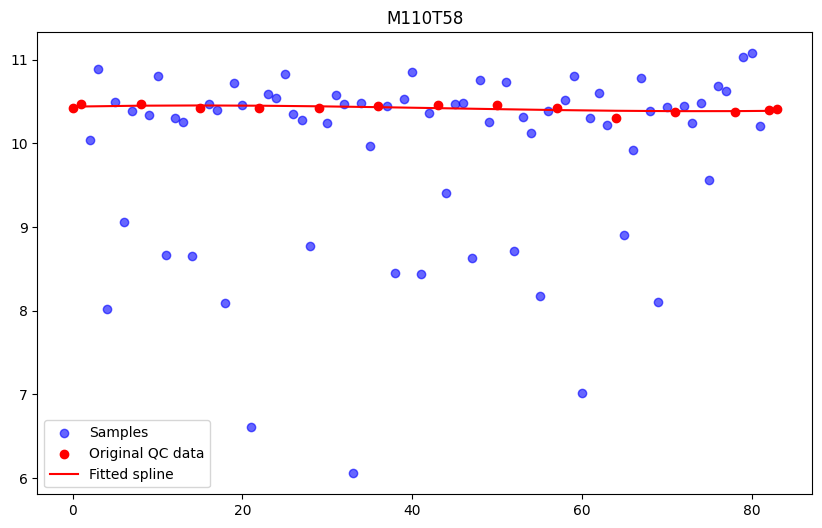

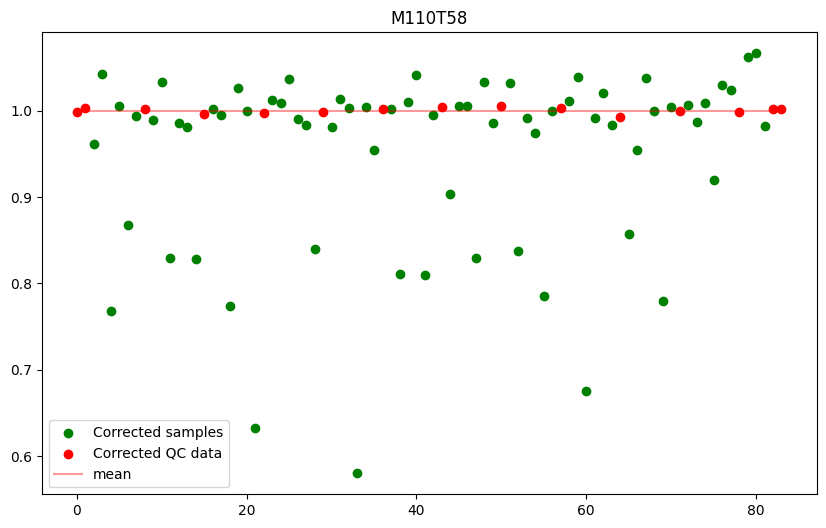

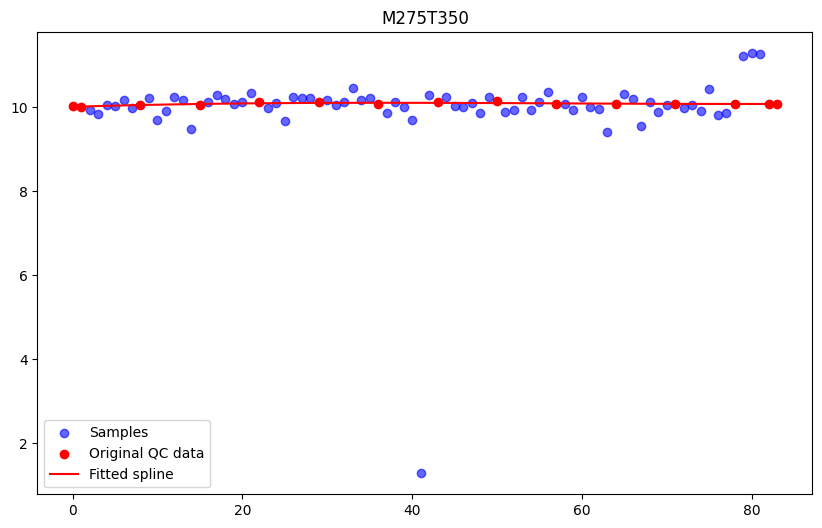

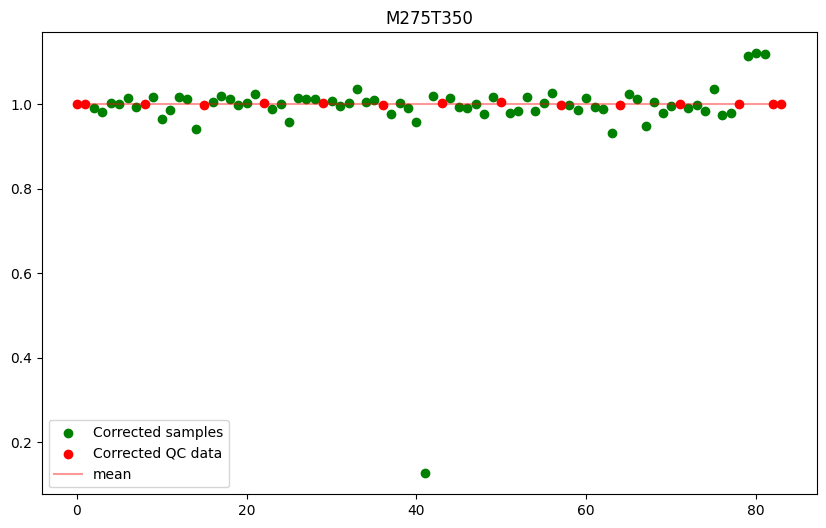

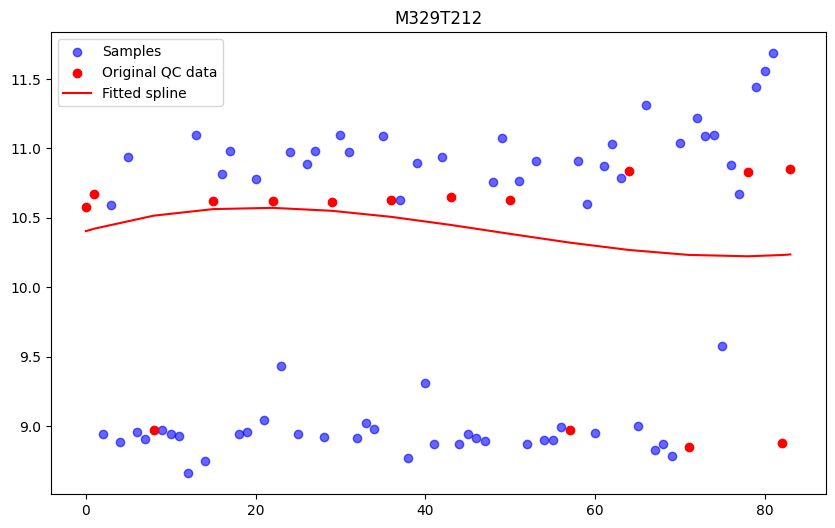

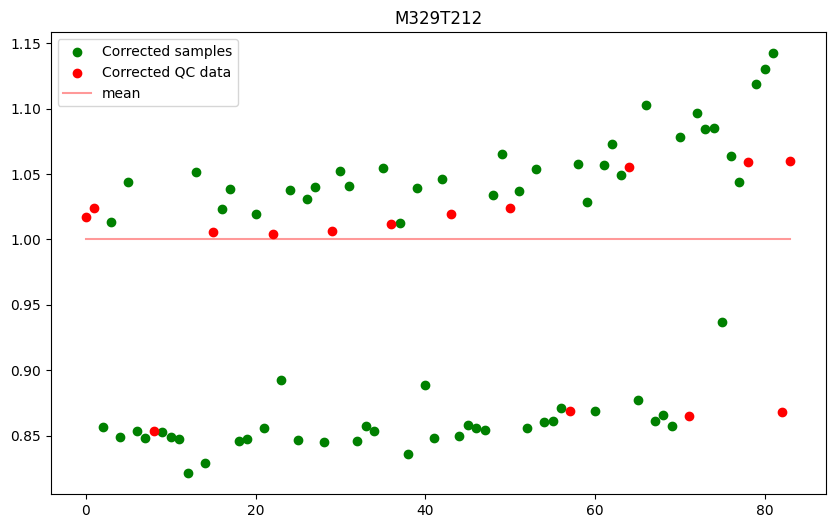

Progress: 100.0%; last chosen p: 8.708497377870819. Time estimate: 0.0m         
Done


In [ ]:
# Kirwan JA, Broadhurst DI, Davidson RL, Viant MR. Characterising and correcting batch variation in an automated direct infusion mass spectrometry (DIMS) metabolomics workflow. Anal Bioanal Chem. 2013 Jun;405(15):5147-57. doi: 10.1007/s00216-013-6856-7. Epub 2013 Mar 1. Erratum in: Anal Bioanal Chem. 2014 Sep;406(24):6075-6. PMID: 23455646.
# DOI 10.1007/s00216-013-6856-7

def log_transformation(df, invert=False):
    if invert:
        return np.exp(df)
    return np.log(df + 0.0001) # Add a small number to avoid log(0) 

def cubic_spline_smoothing(x, y, p, use_norm = True): #if normalization is used, then y is already z-scores
    # Fit a cubic spline to the data
    if use_norm: # Data is already normalized (it is z_scores)
        weights = 1 / (1 + (y - 10)** 2) # 10 is added in normalization
        s = UnivariateSpline(x, y, w = weights, s=p)
    else:
        zscores = zscore(y, axis=0) 
        weights = 1 / (1 + (zscores ** 2))
        s = UnivariateSpline(x, y, w = weights, s=p)   
    return s

def normalize_zscores(data):
    # Calculate the z-scores for the data
    zscores = zscore(data, axis=0) + 10 # Add 10 to avoid division by zero (or close to zero)
    
    # Return the z-scores
    return zscores, zscores.mean(axis=0), zscores.std(axis=0)

def invert_zscores(zscores, mean, std):
    # Invert the z-scores
    mean = mean.to_numpy()
    std = std.to_numpy()

    data = (zscores - 1) * std + mean # Subtract 1 (10 was added, but then it was divided in the correction step)
    
    # Return the inverted z-scores
    return data   

def leave_one_out_cross_validation(x, y, p_values, use_norm = True):
    # Initialize leave-one-out cross validation
    loo = LeaveOneOut()
    
    # Initialize the best smoothing parameter and the minimum mean squared error
    best_p = None
    min_mse = np.inf
    
    # For each smoothing parameter
    for p in p_values:
        # Initialize the mean squared error
        mse = 0
        
        # For each training set and test set
        for train_index, test_index in loo.split(x):
            # Split the data into a training set and a test set
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Fit a cubic spline to the training set
            s = cubic_spline_smoothing(x_train, y_train, p, use_norm)
            
            # Calculate the mean squared error on the test set
            mse += ((s(x_test) - y_test) ** 2).sum()
        
        # Calculate the mean squared error
        mse /= len(x)
        
        # If this is the best smoothing parameter so far, update the best smoothing parameter and the minimum mean squared error
        if mse < min_mse:
            best_p = p
            min_mse = mse
    # Return the best smoothing parameter
    return best_p

def custom_k_fold_cross_validation(x, y, p_values, k = 5, use_norm = True):
    # Initialize the best smoothing parameter and the minimum mean squared error
    best_p = None
    min_mse = np.inf

    # For each smoothing parameter
    for p in p_values:
        # Initialize the mean squared error
        mse = 0

        # For each fold
        for i in range(k):

            # Split the data into a training set and a test set
            x_test = x[i::k]
            y_test = y[i::k]
            x_train = np.setdiff1d(x, x_test)
            y_train = np.setdiff1d(y, y_test)
        
            # Fit a cubic spline to the training set
            s = cubic_spline_smoothing(x_train, y_train, p, use_norm)

            # Calculate the mean squared error on the test set
            mse += ((s(x_test) - y_test) ** 2).sum()

        # Calculate the mean squared error
        mse /= len(x)

        # If this is the best smoothing parameter so far, update the best smoothing parameter and the minimum mean squared error
        if mse < min_mse:
            best_p = p
            min_mse = mse
    # Return the best smoothing parameter
    return best_p

# def normalize_data(x, y, p_values):
#     # Find the best smoothing parameter using leave-one-out cross validation
#     p = custom_k_fold_cross_validation(x, y, p_values, 5)
    
#     # Fit a cubic spline to the data using the best smoothing parameter
#     s = cubic_spline_smoothing(x, y, p)
    
#     # Normalize the data
#     y_normalized = y / s(x)
    
#     # Return the normalized data
#     return y_normalized

def qc_correction(df, qc_columns, feature_names = [], p_values = np.linspace(0.3, 1, 10), show = [0], use_log = True, use_norm = True):
    # Transpose the dataframe
    df = df.T
    df = df.copy()

    if use_log:
        # Apply log transformation to the data
        df = log_transformation(df)
    
    if use_norm:
        df, mean, std = normalize_zscores(df)


    start_time = time.time()

    # Create lists to store the plot names to plot into REPORT
    plot_names_orig = []
    plot_names_corr = []
    
    # For each feature
    chosen_p_values = []
    for feature in df.columns:
        # Get the QC data
        qc_indexes = df.index.isin(qc_columns)
        qc_data = df[qc_indexes]
        x = np.arange(len(df))[qc_indexes]
        y = qc_data[feature].values


        # Fit a cubic spline to the QC data
        p = custom_k_fold_cross_validation(x, y, p_values, 5, use_norm)
        chosen_p_values.append(p)
        s = cubic_spline_smoothing(x, y, p, use_norm)

        #Print out progress
        percentage_done = round((feature + 1) / len(df.columns) * 100, 3)
        print(f'Progress: {percentage_done}%; last chosen p: {p}. Time estimate: {round((time.time() - start_time) / (feature + 1) * (len(df.columns) - feature - 1)/60, 2)}m       ', end='\r')

        # Predict the feature values for the QC samples
        y_pred = s(x)

        # Get the non-QC data
        non_qc_indexes = ~df.index.isin(qc_columns)
        non_qc_data = df[non_qc_indexes]
        x_non_qc = np.arange(len(df))[non_qc_indexes]
        y_non_qc = non_qc_data[feature].values

       
        # Plot the original QC data and the fitted spline
        if feature in show:
            plt.figure(figsize=(10, 6))
            plt.scatter(x_non_qc, y_non_qc, label='Samples', color = 'blue', alpha = 0.6)
            plt.scatter(x, y, label='Original QC data', color = 'red') 
            plt.plot(x, y_pred, color='red', label='Fitted spline')
            if len(feature_names) > 0:
                plt.title(feature_names[feature])
            else:
                plt.title(f'Feature: {feature}')
            plt.legend()
            #Save the plot
            for sufix in sufixes:
                plt_name = main_folder + '/figures/QC_correction_' + str(feature) + '_original'
                plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
            plot_names_orig.append(plt_name +'.png')
            plt.show()

        # Use fitted spline to correct all the data for the feature
        df[feature] = df[feature] / abs(s(np.arange(len(df))))

        non_qc_data_corrected = df[non_qc_indexes][feature].values
        qc_data_corrected = df[qc_indexes][feature].values
        
        if feature in show:
            # Plot the corrected data
            plt.figure(figsize=(10, 6))
            plt.scatter(x_non_qc, non_qc_data_corrected, label='Corrected samples', color = 'green')
            plt.scatter(x, qc_data_corrected, label='Corrected QC data', color = 'red')
            # plot a line at the 1
            plt.plot(x, [1 for i in range(len(x))], color='red', label='mean', alpha = 0.4)
            if len(feature_names) > 0:
                plt.title(feature_names[feature])
            else:
                plt.title(f'Feature: {feature}')
            plt.legend()
            #Save the plot
            for sufix in sufixes:
                plt_name = main_folder + '/figures/QC_correction_' + str(feature) + '_corrected'
                plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
            plot_names_corr.append(plt_name +'.png')
            plt.show()

    # Create a dictionary with the chosen p values
    chosen_p_values = pd.Series(chosen_p_values).value_counts().to_dict()
    # Sort the dictionary by the number of occurrences
    chosen_p_values = {k: v for k, v in sorted(chosen_p_values.items(), key=lambda item: item[1], reverse=True)}


    if use_norm:
        # Calculate new std
        #std_new = df.std(axis=0)

        # Invert the normalization (based on the old mean and the new std (is it good or bad?)) 
        df = invert_zscores(df, mean, std)

    if use_log:
        # Invert the log transformation
        df= log_transformation(df, invert=True)


    # Transpose the dataframe back    
    df = df.T
    # Add cpdID as a first column (back)
    df.insert(0, 'cpdID', f_names)

    #---------------------------------------------
    #REPORTING 1
    text0 = 'QC correction was performed.'
    texts = []
    text1 = 'In the correction process, the data ' + ('WAS' if use_log else "WASN'T") + ' log-transformed and ' + ('WAS' if use_norm else "WASN'T") +' normalized.'
    texts.append(('text', text1, 'italic'))
    if use_log or use_norm:
        text2 = 'This step was then inverted after the correction.'
        texts.append(('text', text2, 'italic'))
    text3 = "The smoothing parameter was optimized using variation of k-fold cross-validation from a range defined as <m-math.sqrt(2*m), m+math.sqrt(2*m)>. which was: <"+ str(int(m-math.sqrt(2*m))) + "; " + str(int(m+math.sqrt(2*m))) + ">; where m is the amount of data-points interpolated (in this case the number of QCs)"
    texts.append(('text', text3))
    together = [('text', text0, 'bold')]
    together.extend(texts)
    report.add_together(together)
    report.add_line()
    for plot_names in zip(plot_names_orig, plot_names_corr):
        report.add_together([('text', 'Original data:', 'bold'),
                            ('image', plot_names[0]),
                            ('text', 'Corrected data:', 'bold'),
                            ('image', plot_names[1]),
                            'line'])
    return df

f_names = data.iloc[:, 0]
df = data.iloc[:, 1:]
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
qc_columns = data.columns[1:][is_qc_sample]

#Citation: "Recommended values of s depend on the weights, w. If the weights represent the inverse of the standard-deviation of y, then a good s value should be found in the range (m-sqrt(2*m),m+sqrt(2*m)) where m is the number of datapoints in x, y, and w." (standard-deviation is wrong tho, that doesn't work for each datapoint...) 
m = len(qc_columns) - 1
print(m-math.sqrt(2*m))
print(m+math.sqrt(2*m))
p_values = np.linspace(m-math.sqrt(2*m), m+math.sqrt(2*m), 10)

to_show = [i for i in range(10)] + [1211]

data = qc_correction(df, qc_columns, f_names,p_values, show = to_show, use_log = True, use_norm = True)
print()
print('Done')

#---------------------------------------------
#REPORTING 2
report.add_pagebreak()


In [ ]:
data

,cpdID,Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),Area: B_K_02_R_POS.raw (F2),Area: C_Ol_02_N_POS.raw (F11),Area: KR_K_01_R_POS.raw (F72),Area: KE_Ol_01_N_POS.raw (F66),Area: G_K_03_R_POS.raw (F53),Area: QC13_POS.raw (F99),...,Area: H_Ol_01_R_POS.raw (F58),Area: H_Ol_03_N_POS.raw (F61),Area: Bez_Op_02_R_POS.raw (F5),Area: KU_Op_01_R_POS.raw (F81),Area: QC23_POS.raw (F109),Area: ES_01_POS.raw (F42),Area: ES_02_POS.raw (F43),Area: ES_03_POS.raw (F44),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111)
0,M138T350,22146.729581,21942.060205,21636.652432,15303.363723,23116.228228,21407.844154,23718.226816,21837.268397,22184.085786,...,21711.217992,24588.661489,21020.026757,21315.763841,21887.021388,31007.065714,31779.501913,30796.117320,22144.342027,22130.732252
1,M195T46,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
2,M195T46_1,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
3,M195T45,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
4,M94T225,22117.483153,21947.672766,21566.517731,22484.186249,18382.720020,21636.662216,20110.710934,22084.976125,22012.755777,...,21748.318390,20004.085508,22442.714444,22887.064402,22038.295096,23376.466042,23712.755122,22386.522890,22126.854192,21946.945219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,M222T314,21860.560874,22139.816459,22686.893699,22100.593222,17650.242629,22952.568275,18407.669027,22424.956935,22106.107766,...,22530.324286,19816.143771,22171.637653,22203.773492,22100.959356,23584.243811,23898.723223,23817.571535,22022.867996,21923.561179
2485,M363T312,22257.784057,21896.253310,22744.136271,21850.946545,17101.925886,22534.449107,19728.858018,23375.594392,21945.546131,...,22171.224882,17996.255773,22209.964136,21967.465149,22420.035575,23040.745854,23894.125611,22993.620351,21717.459995,22230.988334
2486,M303T340,21803.613687,23005.037410,23371.904798,22860.967826,22009.103443,22193.222121,23722.870210,21906.199240,22737.607359,...,21996.908558,19037.589542,16694.185535,20166.036809,18323.778831,18811.072089,18627.969739,18378.651172,22523.549076,21942.670543
2487,M264T311,22772.831753,21927.895748,22167.463308,21815.904821,17826.845635,21757.363925,18972.419457,23108.994681,22088.888024,...,21941.615735,17863.272471,20827.936725,21717.472650,21954.839256,19593.830574,21646.686236,22232.763120,22170.002945,22273.739914


### RSD% Filter on QC samples

In [ ]:
#WHEN TO DO THIS? BEFORE OR AFTER DATA TRANSFORMATION?
#calculate before and after batch correction (but filter after)
#if one compound is unstable and has high rsd for QC, then this compound is ommited from the analysis
#QC RSD% > 20% removed
rsd_threshold = 20

#filter our quality-control samples (QC)
QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist()
#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

#Calculate RSD for only QC samples
qc_rsd = data[data.columns[1:][is_qc_sample]].std(axis=1)/data[data.columns[1:][is_qc_sample]].mean(axis=1)*100

#Filter out features (compounds) with RSD > rsd_threshold
data = data[qc_rsd <= rsd_threshold]
print(data.shape)

#Plot some of the compounds with high RSD
number_plotted = 4
indexes = qc_rsd[qc_rsd > rsd_threshold].index.tolist()[:number_plotted]
if len(indexes) < number_plotted:
    number_plotted = len(indexes)
if len(indexes)  == 0:
    print("No compounds with RSD > " + str(rsd_threshold) + " were found.")
else:   
    alphas = [0.5 if qc else 0.7 for qc in is_qc_sample]
    colors = ['grey' if qc else 'blue' for qc in is_qc_sample]
    for i in range(number_plotted):
        plt.scatter(range(len(data.columns[1:])), data.iloc[indexes[i],1:], color= colors, alpha=alphas, marker='o')
        plt.xlabel('Samples in order')
        plt.ylabel('Peak Area')
        plt.title("High RSD compound: cpID = " + data.iloc[indexes[i], 0])
        for sufix in sufixes:
            plt.savefig(main_folder + '/figures/QC_samples_scatter_' + str(indexes[i]) + '_high_RSD-deleted_by_correction' + sufix, dpi=400, bbox_inches='tight')
            plt.show()

#report how many features were removed
print("Number of features removed: " + str(len(qc_rsd[qc_rsd > rsd_threshold])) + " ;being: " + str(qc_rsd[qc_rsd > rsd_threshold].index.tolist()))

#---------------------------------------------
#REPORTING
text0 = 'Features with RSD% over the threshold (' + str(rsd_threshold) + ') were removed.'
if len(indexes) == 0:
    text1 = 'No compounds with RSD > ' + str(rsd_threshold) + ' were found.'
    report.add_together([('text', text0),
                    ('text', text1)])
else:
    text1 = 'Number of features removed: ' + str(len(qc_rsd[qc_rsd > rsd_threshold])) + ' ;being: '+ str(qc_rsd[qc_rsd > rsd_threshold].index.tolist()[:10])[:-1] + ', ...'
    text2 = 'Examples of compounds with high RSD%:'
    report.add_together([('text', text0),
                    ('text', text1),
                    ('text', text2)])
    images = [main_folder + '/figures/QC_samples_scatter_' + str(indexes[i]) + '_high_RSD-deleted_by_correction' for i in range(number_plotted)]
    for image in images:
        report.add_image(image)
report.add_line()

(2489, 85)
No compounds with RSD > 20 were found.
Number of features removed: 0 ;being: []


In [ ]:
data

,cpdID,Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),Area: B_K_02_R_POS.raw (F2),Area: C_Ol_02_N_POS.raw (F11),Area: KR_K_01_R_POS.raw (F72),Area: KE_Ol_01_N_POS.raw (F66),Area: G_K_03_R_POS.raw (F53),Area: QC13_POS.raw (F99),...,Area: H_Ol_01_R_POS.raw (F58),Area: H_Ol_03_N_POS.raw (F61),Area: Bez_Op_02_R_POS.raw (F5),Area: KU_Op_01_R_POS.raw (F81),Area: QC23_POS.raw (F109),Area: ES_01_POS.raw (F42),Area: ES_02_POS.raw (F43),Area: ES_03_POS.raw (F44),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111)
0,M138T350,22146.729581,21942.060205,21636.652432,15303.363723,23116.228228,21407.844154,23718.226816,21837.268397,22184.085786,...,21711.217992,24588.661489,21020.026757,21315.763841,21887.021388,31007.065714,31779.501913,30796.117320,22144.342027,22130.732252
1,M195T46,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
2,M195T46_1,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
3,M195T45,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
4,M94T225,22117.483153,21947.672766,21566.517731,22484.186249,18382.720020,21636.662216,20110.710934,22084.976125,22012.755777,...,21748.318390,20004.085508,22442.714444,22887.064402,22038.295096,23376.466042,23712.755122,22386.522890,22126.854192,21946.945219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,M222T314,21860.560874,22139.816459,22686.893699,22100.593222,17650.242629,22952.568275,18407.669027,22424.956935,22106.107766,...,22530.324286,19816.143771,22171.637653,22203.773492,22100.959356,23584.243811,23898.723223,23817.571535,22022.867996,21923.561179
2485,M363T312,22257.784057,21896.253310,22744.136271,21850.946545,17101.925886,22534.449107,19728.858018,23375.594392,21945.546131,...,22171.224882,17996.255773,22209.964136,21967.465149,22420.035575,23040.745854,23894.125611,22993.620351,21717.459995,22230.988334
2486,M303T340,21803.613687,23005.037410,23371.904798,22860.967826,22009.103443,22193.222121,23722.870210,21906.199240,22737.607359,...,21996.908558,19037.589542,16694.185535,20166.036809,18323.778831,18811.072089,18627.969739,18378.651172,22523.549076,21942.670543
2487,M264T311,22772.831753,21927.895748,22167.463308,21815.904821,17826.845635,21757.363925,18972.419457,23108.994681,22088.888024,...,21941.615735,17863.272471,20827.936725,21717.472650,21954.839256,19593.830574,21646.686236,22232.763120,22170.002945,22273.739914


In [ ]:
data.to_csv(main_folder + '/' + output_file_prefix + '-data_before_log-transf.csv', index = False, sep = ';')   #save the data after preprocessing and before logaritmic transformation

### Data transformation - NEED TO UPDATE THE CORRECTION TO RETURN BOTH LOGD AND UNLOGD VERSION OF THE DATA (THE LOG SHOULDN'T BE DONE HERE)

In [ ]:
# # Log transformation

# data.iloc[:,1:] = np.log(data.iloc[:,1:].astype(float))

# #---------------------------------------------
# #REPORTING
# text = 'Log transformation was performed.'
# report.add_together([('text', text),
#                     'line'])

### Visualization

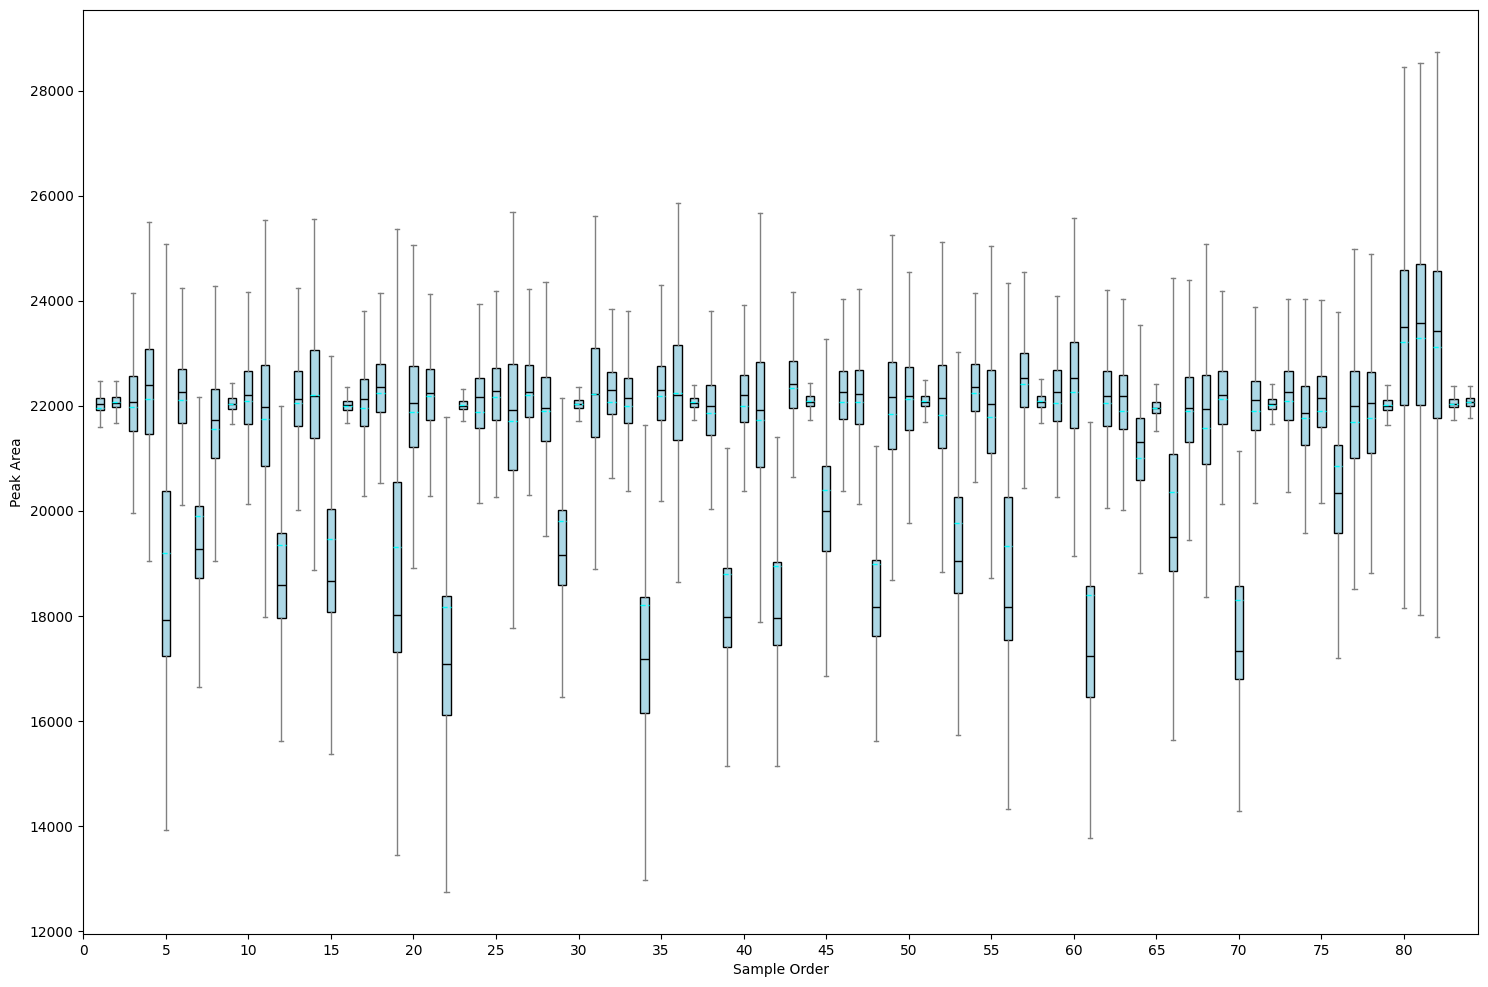

In [ ]:
#filter our quality-control samples (QC)
QC_samples = metadata[metadata['SampleType'] == 'QC']['SampleFile'].tolist()
#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(18, 12))

# Create a box plot for the specific feature
box = plt.boxplot(data.iloc[:,1:], showfliers=False, showmeans=True, meanline=True, medianprops={'color':'black'}, meanprops={'color':'cyan'}, patch_artist=True, whiskerprops=dict(color='grey'), capprops=dict(color='grey'))

#Color boxplots of QC samples in red and the rest in blue
colors = ['red' if qc else 'lightblue' for qc in is_qc_sample]
# Set the colors for the individual boxplots
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize the plot
plt.xlabel('Sample Order')
plt.ylabel('Peak Area')

xx = np.arange(0, len(data.columns[1:])+1, 5)
plt.xticks(xx, xx)
for sufix in sufixes:
    plt.savefig(main_folder + '/figures/QC_samples_boxplot_after_log-transf' + sufix, dpi=400, bbox_inches='tight')
plt.show()

#---------------------------------------------
#REPORTING
text = 'View of samples after log transformation.'
report.add_together([('text', text),
                    ('image', main_folder + '/figures/QC_samples_boxplot_after_log-transf'),
                    'line'])


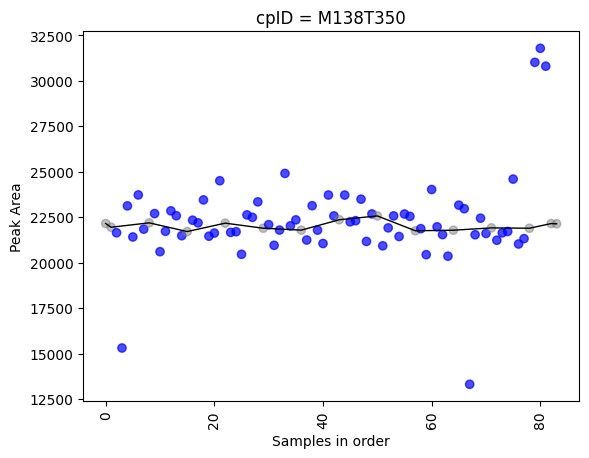

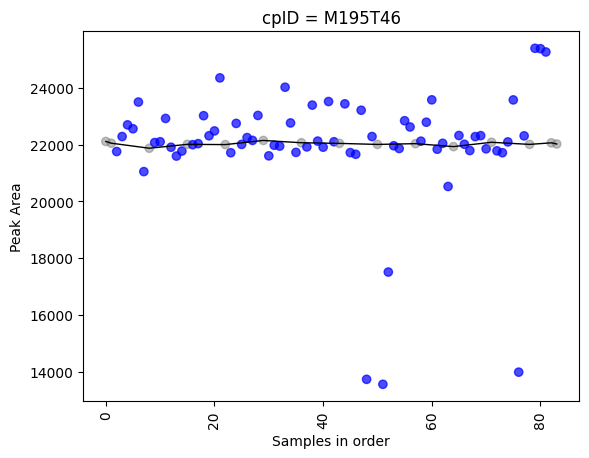

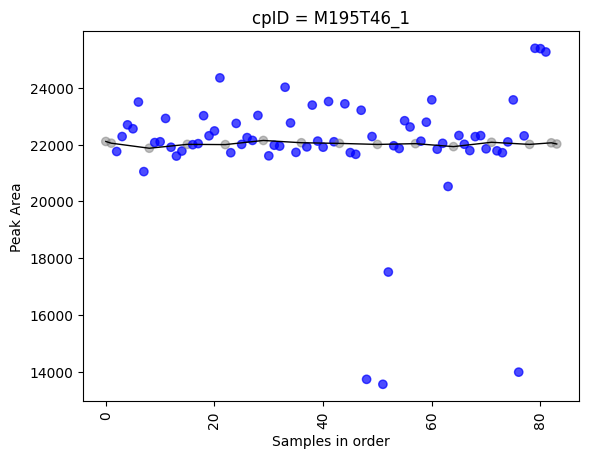

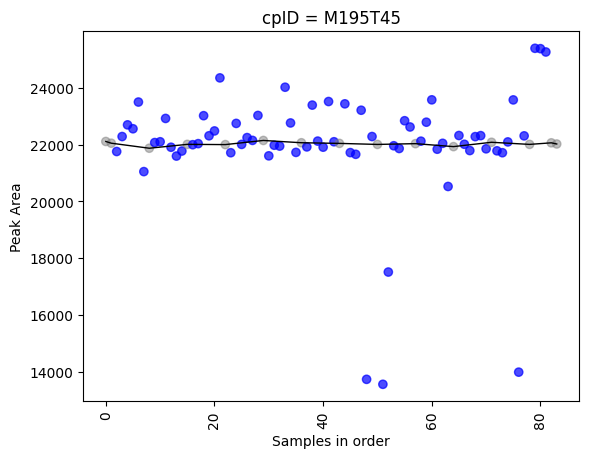

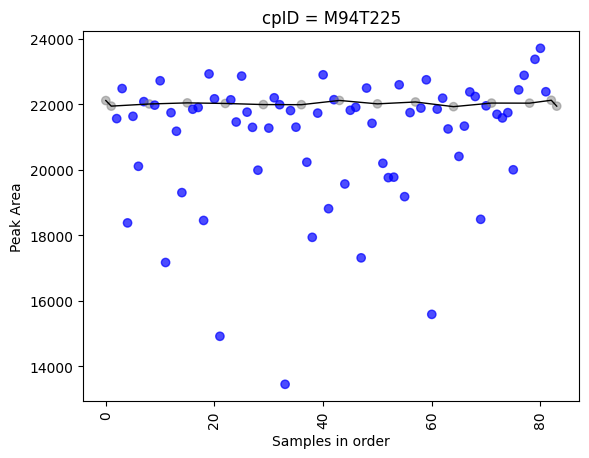

In [ ]:
# compounds to visualize
indexes = [0, 1, 2, 3, 4]

#filter our quality-control samples (QC)
QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist() 
#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
plt_names = []

alphas = [0.5 if qc else 0.7 for qc in is_qc_sample]
colors = ['grey' if qc else 'blue' for qc in is_qc_sample]

x_mask = np.array(is_qc_sample)

for index in indexes:
    # Create a scatter plot to display the non QC sample points
    plt.scatter(range(len(data.columns) -1), data.iloc[index, 1:], color= colors, alpha=alphas, marker='o')

    #plot the function for QC samples
    plt.plot(np.arange(len(data.columns) - 1)[x_mask], data.iloc[index, 1:][is_qc_sample], color='black', linewidth=1)

    plt.xticks(rotation=90)
    plt.xlabel('Samples in order')
    plt.ylabel('Peak Area')
    plt.title("cpID = " + data.iloc[index, 0])
    for sufix in sufixes:
        plt_name = main_folder + '/figures/single_compound-' + str(index) + '-after_corrections' + sufix
        plt.savefig(plt_name, dpi=400, bbox_inches='tight')
    plt.show()

#---------------------------------------------
#REPORTING
text = 'View of samples for a single compound after the corrections.'
report.add_text(text)
#add plots to the report
for index in indexes:
    image = main_folder + '/figures/single_compound-' + str(index) + '-after_corrections'
    report.add_image(image)
report.add_line()

In [ ]:
data

,cpdID,Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),Area: B_K_02_R_POS.raw (F2),Area: C_Ol_02_N_POS.raw (F11),Area: KR_K_01_R_POS.raw (F72),Area: KE_Ol_01_N_POS.raw (F66),Area: G_K_03_R_POS.raw (F53),Area: QC13_POS.raw (F99),...,Area: H_Ol_01_R_POS.raw (F58),Area: H_Ol_03_N_POS.raw (F61),Area: Bez_Op_02_R_POS.raw (F5),Area: KU_Op_01_R_POS.raw (F81),Area: QC23_POS.raw (F109),Area: ES_01_POS.raw (F42),Area: ES_02_POS.raw (F43),Area: ES_03_POS.raw (F44),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111)
0,M138T350,22146.729581,21942.060205,21636.652432,15303.363723,23116.228228,21407.844154,23718.226816,21837.268397,22184.085786,...,21711.217992,24588.661489,21020.026757,21315.763841,21887.021388,31007.065714,31779.501913,30796.117320,22144.342027,22130.732252
1,M195T46,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
2,M195T46_1,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
3,M195T45,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,22092.188872,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759
4,M94T225,22117.483153,21947.672766,21566.517731,22484.186249,18382.720020,21636.662216,20110.710934,22084.976125,22012.755777,...,21748.318390,20004.085508,22442.714444,22887.064402,22038.295096,23376.466042,23712.755122,22386.522890,22126.854192,21946.945219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,M222T314,21860.560874,22139.816459,22686.893699,22100.593222,17650.242629,22952.568275,18407.669027,22424.956935,22106.107766,...,22530.324286,19816.143771,22171.637653,22203.773492,22100.959356,23584.243811,23898.723223,23817.571535,22022.867996,21923.561179
2485,M363T312,22257.784057,21896.253310,22744.136271,21850.946545,17101.925886,22534.449107,19728.858018,23375.594392,21945.546131,...,22171.224882,17996.255773,22209.964136,21967.465149,22420.035575,23040.745854,23894.125611,22993.620351,21717.459995,22230.988334
2486,M303T340,21803.613687,23005.037410,23371.904798,22860.967826,22009.103443,22193.222121,23722.870210,21906.199240,22737.607359,...,21996.908558,19037.589542,16694.185535,20166.036809,18323.778831,18811.072089,18627.969739,18378.651172,22523.549076,21942.670543
2487,M264T311,22772.831753,21927.895748,22167.463308,21815.904821,17826.845635,21757.363925,18972.419457,23108.994681,22088.888024,...,21941.615735,17863.272471,20827.936725,21717.472650,21954.839256,19593.830574,21646.686236,22232.763120,22170.002945,22273.739914


## Finishing touches

In [ ]:
# SAVE THE PROCESSED DATA
data = data.reset_index(drop=True)
data.to_csv(main_folder + '/' + output_file_prefix +'-data.csv', sep = ';')

variable_metadata = variable_metadata.reset_index(drop=True)
variable_metadata.to_csv(main_folder + '/' + output_file_prefix+'-variable_metadata.csv', sep = ';')

metadata = metadata.reset_index(drop=True)
metadata.to_csv(main_folder + '/' + output_file_prefix+'-metadata.csv', sep = ';')

#---------------------------------------------
#REPORTING
text0 = 'Processed data was saved into a files named as follows:'
data_list = ['data_before_log-transf.csv', 'data.csv', 'variable_metadata.csv', 'metadata.csv']
text1 = ''
for file in data_list:
    text1 += '<br/>' + output_file_prefix + '-' + file
report.add_together([('text', text0, 'bold'),
                    ('text', text1, 'italic', 'center'),
                    'line'])

In [ ]:
#----------------------------------------------
#Build the pdf file
report.finalize_report()